#**Sinhala Text Classification Pipeline**

#### Install Packages, Import Libraries and set up Google drive

In [ ]:
# setup google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Uncomment to install packages and restart before running the rest

In [ ]:
# !pip install -q numpy==1.26.4
# !pip install evaluate -q
# !pip install gensim  -q
# !pip install datasets -q
# !pip install grapheme -q
# !pip install torch -q
# !pip install sentence-transformers -q
# !pip install gradio  -q

In [ ]:
# Core libraries
import os
import re
import glob
import json
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# Natural Language Processing (NLP) libraries
import gensim
import grapheme
import unicodedata
import regex as re
from nltk import ngrams
from nltk import FreqDist
import sentencepiece as spm

# Tokenization libraries
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, BertWordPieceTokenizer, processors
from transformers import AutoTokenizer, T5Tokenizer, BertTokenizer, Trainer, TrainingArguments, RobertaForSequenceClassification, EarlyStoppingCallback

# Machine learning and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize, normalize, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Sampling techniques for imbalanced data
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Gensim models
from gensim.models import Word2Vec, FastText

# Datasets and evaluation
from datasets import Dataset, DatasetDict
import evaluate

# Scipy for distance metrics
from scipy.spatial.distance import cosine

# Gradio for UI
import gradio as gr

---

## Task 1 :  Testing and training Tokenizers

### 1.1 .Data Loading

English Sample text corpus was taken from [Andrej Karpathy's Github repository on training a Byte Pair Encoding (BPE) algorithm](https://github.com/karpathy/minbpe/blob/master/tests/taylorswift.txt)

[Sinhala Text corpus](https://huggingface.co/datasets/janani-rane/Sinhala-News-Wiki-text-corpus) is a dataset I scraped from Sinhala News sites and Sinhala Wikipedia articles using BeautifulSoup library.

In [ ]:
# Will be used to observe the behaviour of pre-trained tokenizers on English data
Eng_corpus_path = '/content/drive/MyDrive/NLP/Data /taylorswift.txt'

with open(Eng_corpus_path, 'r') as file:
    lines = file.readlines()
df_en = pd.DataFrame(lines, columns=['context'])

In [ ]:
# Will be used to train all the sinhala tokenizers
corpus_path = r'/content/drive/MyDrive/NLP/Data /sinhala_news_wiki_data.json'

with open(corpus_path, 'r', encoding='utf-8') as f:
    text_corpus = json.load(f)
text_corpus = pd.DataFrame(text_corpus)

### 1.2. Data Descriptions and EDA

#### 1.2.1. General Overview of corpus

In [ ]:
print(f"Shape of English dataset: {df_en.shape}\n")
print(f"Shape of Sinhala dataset: {text_corpus.shape}\n")

Shape of English dataset: (988, 1)

Shape of Sinhala dataset: (18201, 8)



In [ ]:
print('English Dataset: \n')
df_en.info()

English Dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   context  988 non-null    object
dtypes: object(1)
memory usage: 7.8+ KB


In [ ]:
#English Dataset contains data extracted relating to an Artist
df_en.tail(5)

,context
983,Categories: Taylor Swift1989 birthsLiving peop...
984,"This page was last edited on 16 February 2024,..."
985,Text is available under the Creative Commons A...
986,Privacy policyAbout WikipediaDisclaimersContac...
987,Wikimedia FoundationPowered by MediaWiki\n


In [ ]:
# print sinhala dataset
text_corpus.head(4)

,category,site,url,title,context,id,context_length,context_word_count
0,Other-news,lankadeepa,https://www.lankadeepa.lk/news/100-හවරද-ගවන-සබ...,100 හැවිරිදි ගුවන් සෙබළ 96 පෙම්වතිය සමග අතින්...,දෙවැනි ලෝක යුද්ධ සමයේදී ඇමෙරිකානු ගුවන් හමුදාව...,167b3e5cc9434b74b7416fc7_part13813,1068,167
1,Other-news,lankadeepa,https://www.lankadeepa.lk/news/13-වසරක-ඉලලන-ක-...,13 වසරක් ඉල්ලන් කෑ හිඟන්න කෑම පරක්කු වුණැයි ඔ...,වසර දහතුනක් තිස්සේ දිවා ආහාරය ලබා දුන් හෝටල් හ...,f563315540224304a941e8f1_part19508,1196,184
2,Other-news,lankadeepa,https://www.lankadeepa.lk/news/14-වන-මහලන-වට-ප...,14 වන මහලෙන් වැටී පුද්ගලයෙක් මරුට,බොරැල්ල ඩි එස් සේනානායක මාවතේ ඉදිකරමින් පවතින...,e90027ffe8ce455d86d1e86a_part19221,466,71
3,Other-news,lankadeepa,https://www.lankadeepa.lk/news/15-රජය-නවඩ-දනයක...,15 රජයේ නිවාඩු දිනයක්,සිංහල සහ දෙමළ අලුත් අවුරුද්ද වෙනුවෙන් මෙම මස 1...,5ca2a2fe2e3b423a95f8900c_part15635,383,61


In [ ]:
print(df_en.info()) # English dataset overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   context  988 non-null    object
dtypes: object(1)
memory usage: 7.8+ KB
None


In [ ]:
print(text_corpus.info()) # Overview of Sinhala dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18201 entries, 0 to 18200
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            18201 non-null  object
 1   site                18201 non-null  object
 2   url                 18201 non-null  object
 3   title               18201 non-null  object
 4   context             18201 non-null  object
 5   id                  18201 non-null  object
 6   context_length      18201 non-null  int64 
 7   context_word_count  18201 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.1+ MB
None


In [ ]:
# Statistics from  datasets
print(f" English dataset basic stats:\n{df_en.describe()}\n")
print(f"Sinhala dataset basic stats:\n{text_corpus.describe()}")

 English dataset basic stats:
       context
count      988
unique     953
top         \n
freq        13

Sinhala dataset basic stats:
       context_length  context_word_count
count    18201.000000        18201.000000
mean       616.762705           93.763639
std        393.346684           59.355232
min         68.000000           15.000000
25%        337.000000           51.000000
50%        528.000000           80.000000
75%        792.000000          121.000000
max       2000.000000          340.000000


In [ ]:
# Function to get count of sentence in corpus
def count_sentences(text):
    sentences = re.split(r'[.!?]', text)
    return len([s for s in sentences if s.strip()])

total_sentences = df_en['context'].apply(count_sentences).sum()
print(f"Total number of sentences in English dataset: {total_sentences}")
total_sentences = text_corpus['context'].apply(count_sentences).sum()
print(f"Total number of sentences in Sinhala dataset: {total_sentences}")

Total number of sentences in English dataset: 4034
Total number of sentences in Sinhala dataset: 92488


In [ ]:
# Characters in dataset (including White Spaces)
total_characters = df_en['context'].str.len().sum()
print(f"Total characters in English Dataset: {total_characters}")
total_characters = text_corpus['context'].str.len().sum()
print(f"Total characters in Sinhala Dataset: {total_characters}")

Total characters in English Dataset: 185561
Total characters in Sinhala Dataset: 11225698


In [ ]:
# Calculate the total number of characters excluding spaces
total_characters_excluding_spaces = df_en['context'].str.replace(' ', '').str.len().sum()
print(f"Total characters excluding spaces in English dataset: {total_characters_excluding_spaces}")
total_characters_excluding_spaces = text_corpus['context'].str.replace(' ', '').str.len().sum()
print(f"Total characters excluding spaces in Sinhala dataset: {total_characters_excluding_spaces}")

Total characters excluding spaces in English dataset: 157641
Total characters excluding spaces in Sinhala dataset: 9537044


#### 1.2.2. Text and Vocabulary Analysis for Sinhala corpus

In [ ]:
unique_characters = set(''.join(text_corpus['context']))
unique_char_count = len(unique_characters)
print(f"Unique character count in dataset: {unique_char_count}")

Unique character count in dataset: 361


In [ ]:
# Exclude space from the character counter
char_counter = Counter(''.join(text_corpus['context']))
char_counter_excluding_space = {char: count for char, count in char_counter.items() if char != ' '}

# Get the top 5 most common characters excluding space
top_5_chars_excluding_space = Counter(char_counter_excluding_space).most_common(5)

print("Top 5 unique characters excluding space and their counts:")
for char, count in top_5_chars_excluding_space:
    print(f"Character: {char}, Count: {count}")

Top 5 unique characters excluding space and their counts:
Character: ්, Count: 785498
Character: ි, Count: 699014
Character: න, Count: 552827
Character: ව, Count: 528635
Character: ර, Count: 482651


In [ ]:
# Concatenate all the text in the 'context' column
all_text = ''.join(text_corpus['context'])
# Split the text into graphemes
graphemes = list(grapheme.graphemes(all_text))
# Count the frequency of each grapheme
grapheme_counts = Counter(graphemes)
# Get the top 10 most common graphemes
top_10_graphemes = grapheme_counts.most_common(10)

print("Top 10 graphemes:")
for grapheme, count in top_10_graphemes:
    print(f"{grapheme}: {count}")

Top 10 graphemes:
 : 1688027
ය: 281669
ව: 274088
ර: 238146
න්: 206922
ක: 192495
ම: 186848
න: 183183
ස: 134862
ට: 132411


In [ ]:
# count of unique words
unique_words = set(' '.join(text_corpus['context']).split())
unique_words_count = len(unique_words)
print(f"Unique words count in dataset: {unique_words_count}")

Unique words count in dataset: 132487


In [ ]:
# top 10 words according to frequency
all_text = ' '.join(text_corpus['context'])
# Split the text into words
words = all_text.split()
# Count the frequency of each word
word_counts = Counter(words)
# Get the top 10 most common words
top_10_words = word_counts.most_common(10)


print("Top 10 words:")
for word, count in top_10_words:
    print(f"{word}: {count}")

Top 10 words:
බව: 16931
ඇති: 16822
සහ: 13942
කර: 13706
මෙම: 9986
එම: 9725
අතර: 9609
වන: 8789
සඳහා: 8289
මහතා: 8205


In [ ]:
# Tokenize the context column and generate bigrams
bigrams = []
for text in text_corpus['context']:
    tokens = text.split()
    bigrams.extend(ngrams(tokens, 2))

# Count the frequency of each bigram
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Most common bigrams:")
for bigram, count in most_common_bigrams:
    print(f"{bigram}: {count}")

Most common bigrams:
('ඇති', 'බව'): 3909
('ශ්\u200dරී', 'ලංකා'): 2981
('කර', 'ඇති'): 2796
('ඇති', 'අතර'): 2014
('අත්අඩංගුවට', 'ගෙන'): 1784
('සඳහන්', 'කළේය.'): 1755
('කර', 'තිබේ.'): 1546
('ඒ', 'අනුව'): 1544
('රනිල්', 'වික්\u200dරමසිංහ'): 1489
('ඇති', 'බවත්'): 1460


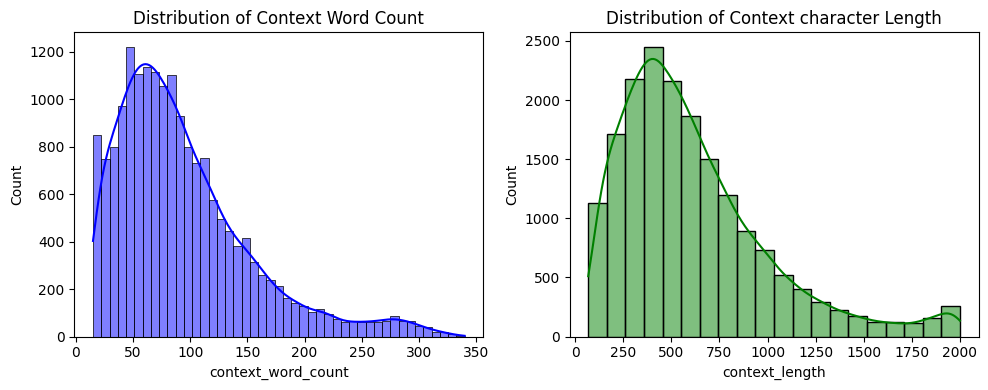

In [ ]:
# Distribution of word count and context length
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(text_corpus['context_word_count'], kde=True, color='blue', bins=45)
plt.title('Distribution of Context Word Count')

plt.subplot(1, 2, 2)
sns.histplot(text_corpus['context_length'], kde=True, color='green', bins=20)
plt.title('Distribution of Context character Length')
plt.tight_layout()
plt.show()

<ipython-input-211-03a836e28035>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=text_corpus['category'].value_counts().index,


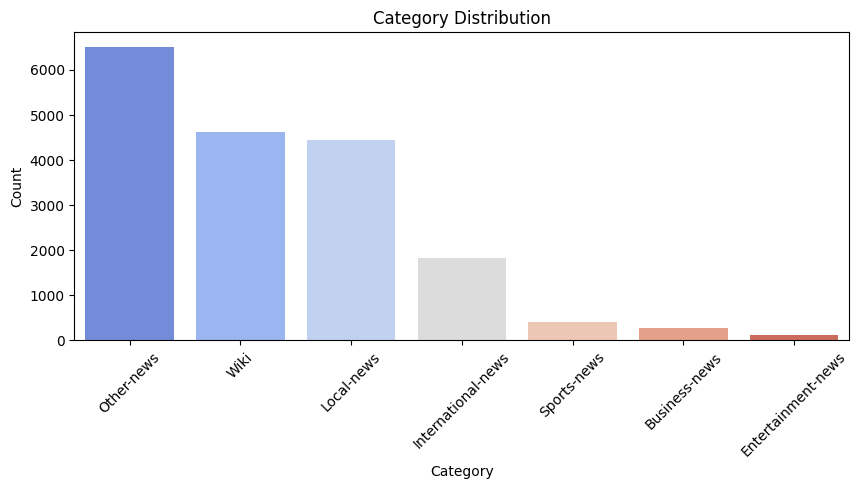

In [ ]:
# Category Distribution
plt.figure(figsize=(10, 4))
sns.barplot(x=text_corpus['category'].value_counts().index,
            y=text_corpus['category'].value_counts().values,
            palette='coolwarm')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


The English Dataset will be used for observing the behaviour of Pre-trained Tokenizers in comparison to Sinhala data. Therefore, since no training is done, the small text corpus will be enough for the task.

The Sinhala News and Wiki Data corpus is the main dataset for the Task 1. The tokenizers will be trained on this dataset. This dataset was chosen after analysing the text and vocabulary features.

Eventhough not as large as NSINA dataset (more than 500,000 articles), the Sinhala dataset chosen has more diversity and variety.

It has diverse categories of data, not limited to News articles as evident from the above plots and also contains a diverse vocabulary.

### 1.3. Cleaning and Preprocessing steps

Few steps were carried out to clean and pre-process the data to be ready to be fed into the tokenizers

In [ ]:
# Function to preprocess text
def preprocess_text(text):

    # Normalize Unicode
    text = unicodedata.normalize('NFC', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Fix sentence boundaries (add space after period if needed)
    text = re.sub(r'(?<!\b[A-Z])\.(?=[^\s\d])', '. ', text)

    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)

    # Remove HTML tags if any
    text = re.sub(r'<.*?>', '', text)

    return text.strip()

In [ ]:
# Perform stratified random split
train_df, test_df = train_test_split(text_corpus, test_size=0.2, stratify=text_corpus['category'], random_state=42)

# Display the shape of the resulting dataframes
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (14560, 8)
Test set shape: (3641, 8)


In [ ]:
# Reset index to avoid issues
test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

In [ ]:
# Preprocess the train and test sets
train_df['context_clean'] = train_df['context'].apply(preprocess_text)
test_df['context_clean'] = test_df['context'].apply(preprocess_text)

In [ ]:
# Display preprocessed text sample
print("\nPreprocessed text:")
print(train_df['context'].iloc[0][:115])


Preprocessed text:
ව්‍යාජ ව්‍යාපාර ලේඛන සකස් කළ බවට හිටපු අමෙරිකානු ජනාධිපති ඩොනල්ඩ් ට්‍රම්ප්ට එරෙහිව එල්ලවූ අපරාධ චෝදනා 34ටම ඔහු වරදක


In [ ]:
# apply pre-processing to English data
df_en['context'] = df_en['context'].apply(preprocess_text)

In [ ]:
# Display preprocessed text sample
print("\nPreprocessed English text:")
print(df_en['context'].iloc[909][:200])


Preprocessed English text:
Lewis, Randy (May 23, 2011). "Taylor Swift benefit concert raises more than $750,000 for tornado victims". Los Angeles Times (Blog). Archived from the original on April 6, 2012. Retrieved April 18, 20


In [ ]:
# Save cleaned dataset
# train_df.to_csv(r'/content/drive/MyDrive/NLP CW 2/Data /Task 2/cleaned_news_wiki_dataset.csv', index=False)

### 1.4. Implementations

#### 1.4.1. Pre-Trained Tokenizers Implementation without Training on Sinhala Corpus

Following pre-trained tokenizers will be tested on Sinhala data and compared against English data performance.

1. bert-base-uncased  -  encoder model
2. gpt2  -   decoder model
3. xlm-roberta-base -  encoder model
4. mt5-small -  encoder-decoder model

While bert-base-uncased and gpt2 are not trained specifically on Sinhala data, xlm-r and mt5-small are pre-trained multilingual models available for Sinhala language

In [ ]:
# dict of pre-trained tokenizers for analysis
tokenizers_pre_trained = {
    "bert-base-uncased": AutoTokenizer.from_pretrained("bert-base-uncased"),
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "xlm-roberta-base": AutoTokenizer.from_pretrained("xlm-roberta-base"),
    "mt5-small" : T5Tokenizer.from_pretrained("google/mt5-small")
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# function to tokenize using pre-trained models
def en_tokenizer(tokenizer, tokenizer_name, text, language):
    """Tokenizes text while handling different tokenizers' truncation settings."""

    # Find the max length for the specific tokenizer
    max_length = tokenizer.model_max_length if hasattr(tokenizer, "model_max_length") else 512

    # Add padding token for tokenizers that don't have (GPT-2)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as padding token if none exists

    # add truncation=True, padding=True
    encoded_input = tokenizer(text, truncation=True, max_length=max_length, padding="max_length" if tokenizer_name == "gpt2" else False)

    tokens = encoded_input['input_ids']

    # Convert token IDs to readable tokens
    token_strings = tokenizer.convert_ids_to_tokens(tokens) if hasattr(tokenizer, "convert_ids_to_tokens") else tokens

    decoded_text = tokenizer.decode(tokens)

    return tokens, token_strings, decoded_text

In [ ]:
# Prepare corpus
training_corpus = train_df['context'].tolist()
test_corpus = test_df['context'].tolist()

In [ ]:
English_text = df_en.loc[909, 'context']
print(f"Sample of Text in English: {English_text}")

Sinhala_text = test_df.loc[100, 'context']
print(f"Sample of Text in Sinhala: {Sinhala_text}")

Sample of Text in English: Lewis, Randy (May 23, 2011). "Taylor Swift benefit concert raises more than $750,000 for tornado victims". Los Angeles Times (Blog). Archived from the original on April 6, 2012. Retrieved April 18, 2012.
Sample of Text in Sinhala: ප්‍රංශයේ පැරිස් අගනුවරට යාබදව පිහිටි “තොයිරි” සත්ත්වෝද්‍යානයේ සිටින වෘකයන් තුන්දෙනකු විසින් සපා කෑම හේතුවෙන් දරුණු තුවාල ලැබූ 37 හැවිරිදි කාන්තාවක් අසාධ්‍ය තත්ත්වයෙන් යුතුව රෝහල්ගත කර තිබේ. වෘකයන් විසින් අදාළ කාන්තාවගේ ගෙල පෙදෙස, පාදයේ පහළ කොටස හා ශරීරයේ පිටුපස කොටස දරුණු ලෙස සපා කා ඇති බව වාර්තා වී තිබේ.


In [ ]:
# try on english data
for name, tokenizer in tokenizers_pre_trained.items():
    en_tokens,en_token_strings, decoded_output = en_tokenizer(tokenizer,name, English_text, 'English')
    print(f"Tokens from {name} for English:\n{en_tokens}")
    print(f"Readable Tokens from {name} for English:\n{en_token_strings}")
    print(f"Decoded Text from {name} for English:\n{decoded_output}\n")

Tokens from bert-base-uncased for English:
[101, 4572, 1010, 9744, 1006, 2089, 2603, 1010, 2249, 1007, 1012, 1000, 4202, 9170, 5770, 4164, 13275, 2062, 2084, 1002, 9683, 1010, 2199, 2005, 11352, 5694, 1000, 1012, 3050, 3349, 2335, 1006, 9927, 1007, 1012, 9749, 2013, 1996, 2434, 2006, 2258, 1020, 1010, 2262, 1012, 5140, 2258, 2324, 1010, 2262, 1012, 102]
Readable Tokens from bert-base-uncased for English:
['[CLS]', 'lewis', ',', 'randy', '(', 'may', '23', ',', '2011', ')', '.', '"', 'taylor', 'swift', 'benefit', 'concert', 'raises', 'more', 'than', '$', '750', ',', '000', 'for', 'tornado', 'victims', '"', '.', 'los', 'angeles', 'times', '(', 'blog', ')', '.', 'archived', 'from', 'the', 'original', 'on', 'april', '6', ',', '2012', '.', 'retrieved', 'april', '18', ',', '2012', '.', '[SEP]']
Decoded Text from bert-base-uncased for English:
[CLS] lewis, randy ( may 23, 2011 ). " taylor swift benefit concert raises more than $ 750, 000 for tornado victims ". los angeles times ( blog ). archi

In [ ]:
# try on sinhala data
for name, tokenizer in tokenizers_pre_trained.items():
    si_tokens,si_token_strings, decoded_output = en_tokenizer(tokenizer,name, Sinhala_text, 'Sinhala')
    print(f"Tokens from {name} for Sinhala:\n{si_tokens}")
    print(f"Readable Tokens from {name} for Sinhala:\n{si_token_strings}")
    print(f"Decoded Text from {name} for Sinhala:\n{decoded_output}\n")

Tokens from bert-base-uncased for Sinhala:
[101, 100, 100, 100, 100, 100, 1523, 100, 1524, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 4261, 100, 100, 100, 100, 100, 100, 1403, 29941, 100, 1012, 100, 100, 100, 100, 100, 100, 1010, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1403, 29944, 100, 100, 100, 1407, 100, 1012, 102]
Readable Tokens from bert-base-uncased for Sinhala:
['[CLS]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '“', '[UNK]', '”', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '37', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'ක', '##ර', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'ක', '##ා', '[UNK]', '[UNK]', '[UNK]', 'ව', '[UNK]', '.', '[SEP]']
Decoded Text from bert-base-uncased for Sinhala:
[CLS] [UNK] [UNK] [UNK] [UNK] [UNK] “ [UNK] ” [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 

#### Intepretation of tokenizers behaviour:

The tokenization of Sinhala text using different models, such as BERT, GPT-2, XLM-Roberta, and mT5-small, shows how each tokenizer handles the same text differently:

BERT (bert-base-uncased):
Tokenized output consists mostly of [UNK] (unknown tokens), indicating that BERT's tokenization does not perform well on Sinhala text. The text has many tokens that cannot be matched by BERT's vocabulary, leading to the replacement of words with [UNK].

GPT-2: GPT-2 also struggles with Sinhala, the tokenization seems to be not aligned with Sinhala language in a meanigful way. However, it performs well when decoding.

XLM-Roberta (xlm-roberta-base):
XLM-Roberta does better with Sinhala, preserving word boundaries and providing a more interpretable tokenization. The subword units are more aligned with the language comapred other pre-trained models tried here.

mT5-small:
mT5-small is another model that handles Sinhala reasonably well, with relatively fewer unknown tokens. It uses more granular subword units but can see not exaclty meaningful tokens.

In terms of readability and understanding of the Sinhala text, mt5  and XLM-Roberta are the most effective, with GPT-2 performing exceptionally well at decoding the meaning in Sinhala, even if the tokenization isn't aligned.

#### 1.4.2. Training Pre-Trained tokenizers on Sinhala Corpus - Implementations

Since BERT tokenizer showed unknown tokens [UNK] for almost all the text, here I trained the BERT tokenizer on Sinhala data to see its performance

In [ ]:
# Create a generator that guve batche of 1000 context
training_corpus = (
    train_df['context'][i : i + 1000].tolist()
    for i in range(0, len(train_df), 1000)
)

In [ ]:
# bert-base-uncased
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased")
si_tokenizer_bert = tokenizer_bert.train_new_from_iterator(training_corpus, 10000)

In [ ]:
si_tokenizer_bert.save_pretrained("/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/si_tokenizer_bert")

('/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/si_tokenizer_bert/tokenizer_config.json',
 '/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/si_tokenizer_bert/special_tokens_map.json',
 '/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/si_tokenizer_bert/vocab.txt',
 '/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/si_tokenizer_bert/added_tokens.json',
 '/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/si_tokenizer_bert/tokenizer.json')

In [ ]:
tokenizers_pre_trained_si = {
    "bert-base-uncased": AutoTokenizer.from_pretrained("bert-base-uncased"),
    "bert-base-uncased-si": si_tokenizer_bert,
}

In [ ]:
# Test how the tokenizer perform after training on sinhala data vs before training on sinhala data
for name, tokenizer in tokenizers_pre_trained_si.items():
    si_tokens, si_token_strings, decoded_output = en_tokenizer(tokenizer, name, Sinhala_text, 'Sinhala')
    print(f"Tokens from {name} for Sinhala:\n{si_tokens}")
    print(f"Readable Tokens from {name} for Sinhala:\n{si_token_strings}")
    print(f"Decoded Text from {name} for Sinhala:\n{decoded_output}\n")


Tokens from bert-base-uncased for Sinhala:
[101, 100, 100, 100, 100, 100, 1523, 100, 1524, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 4261, 100, 100, 100, 100, 100, 100, 1403, 29941, 100, 1012, 100, 100, 100, 100, 100, 100, 1010, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 1403, 29944, 100, 100, 100, 1407, 100, 1012, 102]
Readable Tokens from bert-base-uncased for Sinhala:
['[CLS]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '“', '[UNK]', '”', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '37', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'ක', '##ර', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'ක', '##ා', '[UNK]', '[UNK]', '[UNK]', 'ව', '[UNK]', '.', '[SEP]']
Decoded Text from bert-base-uncased for Sinhala:
[CLS] [UNK] [UNK] [UNK] [UNK] [UNK] “ [UNK] ” [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] 

Intepretation of Results:

From the above outputs it can be observed that BERT without being trained on Sinhala gave [UNK] unknown token to all text but after training on Sinhala data it tokenized in a more meaningful way. It did not give [UNK].


#### 1.4.3. Custom trained Tokenizer for Sinhala

In this section tokenizer will be trained using tokenizers/huggingface libraries. Following tokenizing algorithms wills be tried,

1. Whitespace Tokenizer (Baseline tokenizer)
2. WordPiece Tokenizer
3. BPE Tokenizer
4. SentencePience Tokenizer

All tokenizers are set to 10000 vocab size for consistency when testing.

In [ ]:
# Prepare corpus for tokenizer training
training_corpus = train_df['context'].tolist()
test_corpus = test_df['context'].tolist()

In [ ]:
# whitespace tokenizer - Baseline tokenizer
class WhitespaceTokenizer:
    def __init__(self):
        self.vocab = {}
        self.reverse_vocab = {}

    def train(self, corpus, vocab_size=None):
        """Train tokenizer on corpus (simply build vocabulary)"""
        all_tokens = []
        for text in corpus:
            tokens = text.split()
            all_tokens.extend(tokens)

        # Count token frequencies
        token_counts = Counter(all_tokens)

        # Build vocabulary
        for i, (token, _) in enumerate(token_counts.most_common(vocab_size)):
            self.vocab[token] = i
            self.reverse_vocab[i] = token

        print(f"Whitespace tokenizer vocabulary size: {len(self.vocab)}")

    def tokenize(self, text):
        """Tokenize text using whitespace"""
        return text.split()

    def encode(self, text):
        """Encode text to token IDs"""
        tokens = self.tokenize(text)
        return [self.vocab.get(token, len(self.vocab)) for token in tokens]  # OOV token gets the last index

    def decode(self, ids):
        """Decode token IDs back to text"""
        return " ".join([self.reverse_vocab.get(id, "[UNK]") for id in ids])

In [ ]:
# Instantiate and train whitespace tokenizer
whitespace_tokenizer = WhitespaceTokenizer()
whitespace_tokenizer.train(training_corpus, vocab_size=10000)

Whitespace tokenizer vocabulary size: 10000


In [ ]:
# Train a BertWordPiece tokenizer
def train_bert_wordpiece_tokenizer(corpus, vocab_size=10000, save_path="/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/sinhala_bert_wordpiece_tokenizer.json"):

    # Initialize tokenizer
    tokenizer = BertWordPieceTokenizer(lowercase=False)  # Set True if case-insensitive

    # Start training
    start_time = time.time()
    tokenizer.train_from_iterator(corpus, vocab_size=vocab_size, min_frequency=2, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
    training_time = time.time() - start_time

    # Save the tokenizer
    tokenizer.save(save_path)

    print(f"BERT WordPiece tokenizer trained in {training_time:.2f} seconds")
    print(f"Vocabulary size: {tokenizer.get_vocab_size()}")

    return tokenizer

In [ ]:
bertwordpiece_tokenizer = train_bert_wordpiece_tokenizer(training_corpus, vocab_size=10000)

BERT WordPiece tokenizer trained in 2.14 seconds
Vocabulary size: 10000


In [ ]:
# Train a BPE tokenizer
def train_bpe_tokenizer(corpus, vocab_size=10000, save_path= "/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/sinhala_bpe_tokenizer.json"):
    """Train a BPE tokenizer on the corpus"""
    # Initialize a BPE tokenizer
    tokenizer = Tokenizer(models.BPE())

    # Configure pre-tokenization (split on whitespace and punctuation)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    # Initialize trainer
    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size,
        special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
    )

    # Prepare training data
    def batch_iterator(corpus, batch_size=1000):
        for i in range(0, len(corpus), batch_size):
            yield corpus[i:i+batch_size]

    # Train the tokenizer
    start_time = time.time()
    tokenizer.train_from_iterator(batch_iterator(corpus), trainer=trainer)
    training_time = time.time() - start_time

    # Save the tokenizer
    tokenizer.save(save_path)

    print(f"BPE tokenizer trained in {training_time:.2f} seconds")
    print(f"Vocabulary size: {tokenizer.get_vocab_size()}")

    return tokenizer

In [ ]:
# Train BPE tokenizer
bpe_tokenizer = train_bpe_tokenizer(training_corpus, vocab_size= 10000)

BPE tokenizer trained in 1.63 seconds
Vocabulary size: 10000


In [ ]:
# SentencePiece Tokenizer
def train_sentencepiece_tokenizer(corpus, vocab_size=10000, model_type="unigram", save_prefix="sinhala_sp"):
    """Train a SentencePiece tokenizer on the corpus."""

    # Save corpus to a temporary file (SentencePiece requires file input)
    temp_corpus_path = "/content/drive/MyDrive/NLP CW 2/Artifacts/temp_corpus.txt"
    with open(temp_corpus_path, "w", encoding="utf-8") as f:
        for line in corpus:
            f.write(line.strip() + "\n")

    # Define SentencePiece training parameters
    start_time = time.time()
    spm.SentencePieceTrainer.train(
        input=temp_corpus_path,
        model_prefix=save_prefix,
        vocab_size=vocab_size,
        model_type=model_type,  # Options: unigram, bpe, char, word
        pad_id=3,  # [PAD]
        unk_id=0,  # [UNK]
        bos_id=1,  # [CLS]
        eos_id=2,  # [SEP]
        user_defined_symbols=["[MASK]"]
    )
    training_time = time.time() - start_time

    print(f"SentencePiece tokenizer ({model_type}) trained in {training_time:.2f} seconds")
    print(f"Model files saved as {save_prefix}.model and {save_prefix}.vocab")

    return spm.SentencePieceProcessor(model_file=f"{save_prefix}.model")

In [ ]:
# train sentencepiece tokenizer
sentencepiece_tokenizer = train_sentencepiece_tokenizer(training_corpus, vocab_size=10000, model_type="unigram")

SentencePiece tokenizer (unigram) trained in 10.30 seconds
Model files saved as sinhala_sp.model and sinhala_sp.vocab


In [ ]:
# Get small sample to text behaviour of eac custom tokenizer
sample_text = test_df['context'].iloc[0][:162]

In [ ]:
# Example Usage
tokens = whitespace_tokenizer.encode(sample_text)
decoded_text = whitespace_tokenizer.decode(tokens)
print(f"Sample text: {sample_text}")
print("Tokens:", tokens)
print("Decoded:", decoded_text)

Sample text: ඉරාන ජනාධිපති ඊබ්‍රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්‍රිත්වයකට අයත් යානයක් රළු ගොඩබෑමකට ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා.
Tokens: [1200, 42, 7935, 4235, 71, 104, 199, 4337, 10, 3767, 1201, 10000, 185, 3126, 5427, 10000, 432, 647, 1, 0, 339, 99, 51, 37, 3, 964]
Decoded: ඉරාන ජනාධිපති ඊබ්‍රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා [UNK] අයත් යානයක් රළු [UNK] ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා.


In [ ]:
# Encoding example
bertwordpiece_encoding = bertwordpiece_tokenizer.encode(sample_text)
bertwordpiece_tokens = bertwordpiece_encoding.tokens
decoded_bertwordpiece = bertwordpiece_tokenizer.decode(bertwordpiece_encoding.ids)
print(f"Sample text: {sample_text}")
print(f"BERT WordPiece tokens ({len(bertwordpiece_tokens)}): {bertwordpiece_tokens}")
print("Decoded string WORDPIECE:", decoded_bertwordpiece)

Sample text: ඉරාන ජනාධිපති ඊබ්‍රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්‍රිත්වයකට අයත් යානයක් රළු ගොඩබෑමකට ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා.
BERT WordPiece tokens (34): ['ඉරාන', 'ජනාධිපති', 'ඊ', '##බ්ර', '##හිම්', 'රයිසි', 'ඇතුළු', 'පිරිසක්', 'රැගෙන', 'පියාසර', 'කළ', 'හෙලිකොප්ටර්', 'යානා', 'ත්රි', '##ත්වය', '##කට', 'අයත්', 'යානයක්', 'රළ', '##ු', 'ගොඩබ', '##ෑම', '##කට', 'ලක්', 'ව', 'ඇති', 'බව', 'එරට', 'රාජ්ය', 'මාධ්ය', 'වාර්තා', 'කර', 'තිබුණා', '.']
Decoded string WORDPIECE: ඉරාන ජනාධිපති ඊබ්රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්රිත්වයකට අයත් යානයක් රළු ගොඩබෑමකට ලක් ව ඇති බව එරට රාජ්ය මාධ්ය වාර්තා කර තිබුණා.


In [ ]:
# Test on a sample
bpe_encoding = bpe_tokenizer.encode(sample_text)
bpe_tokens = bpe_encoding.tokens
decoded_bpe = bpe_tokenizer.decode(bpe_encoding.ids)
print(f"Sample text: {sample_text}")
print(f"BPE tokens ({len(bpe_tokens)}): {bpe_tokens}")
print("Decoded string WORDPIECE:", decoded_bpe)

Sample text: ඉරාන ජනාධිපති ඊබ්‍රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්‍රිත්වයකට අයත් යානයක් රළු ගොඩබෑමකට ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා.
BPE tokens (34): ['ඉරාන', 'ජනාධිපති', 'ඊ', 'බ්\u200dර', 'හිම්', 'රයිසි', 'ඇතුළු', 'පිරිසක්', 'රැගෙන', 'පියාසර', 'කළ', 'හෙලිකොප්ටර්', 'යානා', 'ත්\u200dරි', 'ත්වය', 'කට', 'අයත්', 'යානයක්', 'රළු', 'ගොඩ', 'බ', 'ෑම', 'කට', 'ලක්', 'ව', 'ඇති', 'බව', 'එරට', 'රාජ්\u200dය', 'මාධ්\u200dය', 'වාර්තා', 'කර', 'තිබුණා', '.']
Decoded string WORDPIECE: ඉරාන ජනාධිපති ඊ බ්‍ර හිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්‍රි ත්වය කට අයත් යානයක් රළු ගොඩ බ ෑම කට ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා .


In [ ]:
# Test on a sample
sp_encoding = sentencepiece_tokenizer.encode(sample_text, out_type=int)  # Returns token IDs
sp_tokens = sentencepiece_tokenizer.encode(sample_text, out_type=str)  # Returns token pieces
decoded_sp = sentencepiece_tokenizer.decode(sp_encoding)
print(f"Sample text: {sample_text}")
print(f"SentencePiece tokens ({len(sp_tokens)}): {sp_tokens}")
print("Decoded string SentencePiece:", decoded_sp)

Sample text: ඉරාන ජනාධිපති ඊබ්‍රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්‍රිත්වයකට අයත් යානයක් රළු ගොඩබෑමකට ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා.
SentencePiece tokens (34): ['▁ඉරාන', '▁ජනාධිපති', '▁ඊබ්\u200dරහිම්', '▁රයිසි', '▁ඇතුළු', '▁පිරිසක්', '▁රැගෙන', '▁පියා', 'සර', '▁කළ', '▁හෙලිකොප්ටර', '්', '▁යානා', '▁ත්\u200dරි', 'ත්වය', 'කට', '▁අයත්', '▁යානයක්', '▁රළු', '▁ගොඩ', 'බෑ', 'ම', 'කට', '▁ලක්', '▁ව', '▁ඇති', '▁බව', '▁එරට', '▁රාජ්\u200dය', '▁මාධ්\u200dය', '▁වාර්තා', '▁කර', '▁තිබුණා', '.']
Decoded string SentencePiece: ඉරාන ජනාධිපති ඊබ්‍රහිම් රයිසි ඇතුළු පිරිසක් රැගෙන පියාසර කළ හෙලිකොප්ටර් යානා ත්‍රිත්වයකට අයත් යානයක් රළු ගොඩබෑමකට ලක් ව ඇති බව එරට රාජ්‍ය මාධ්‍ය වාර්තා කර තිබුණා.


### 1.5. Evalutation of Tokenizers






Tokenizer will be evaluated using following metric,

1. Compression Ratio
2. Subword Fertility
3. OOV Percentage


(Since bert-base-uncased tokenizer showed only [UNK] tokens it will not be evaluated instead the bert-base-uncased tokenizer I trained on Sinhala data will be used)

In [ ]:
# Dict with all the tokenizers to evaluate
tokenizers_all = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "xlm-roberta-base": AutoTokenizer.from_pretrained("xlm-roberta-base"),
    "mt5-small" : T5Tokenizer.from_pretrained("google/mt5-small"),
    "bert-base-uncased-si": si_tokenizer_bert,
    "whitespace_tokenizer": whitespace_tokenizer,
    "bpe_tokenizer_custom": bpe_tokenizer,
    "sentencepiece_tokenizer": sentencepiece_tokenizer,
    "bertwordpiece_tokenizer": bertwordpiece_tokenizer
}

In [ ]:
def process_text_with_tokenizer(tokenizer, text, max_length=512):
    """Tokenize text and return tokens, original length, and encoded length while handling truncation and padding."""

    # Hugging Face transformers tokenizers (AutoTokenizer, T5Tokenizer, etc.)
    if isinstance(tokenizer, (AutoTokenizer, BertTokenizer)):
        encoded_input = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=max_length
        )
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'])
        encoded_length = len(encoded_input['input_ids'])

    # Tokenizers from the Hugging Face Tokenizers library (BPE, WordPiece)
    elif isinstance(tokenizer, Tokenizer):
        encoding = tokenizer.encode(text)
        tokens = encoding.tokens
        encoded_length = len(tokens)

    # SentencePiece tokenization
    elif isinstance(tokenizer, spm.SentencePieceProcessor):
        tokens = tokenizer.encode(text, out_type=str)
        tokens = tokens[:max_length]  # Manually truncate if needed
        encoded_length = len(tokens)

    # BertWordPieceTokenizer tokenization
    elif isinstance(tokenizer, BertWordPieceTokenizer):
        encoding = tokenizer.encode(text)
        tokens = encoding.tokens
        encoded_length = len(tokens)

    # Handling WhitespaceTokenizer or similar custom tokenizers
    elif hasattr(tokenizer, "encode") and hasattr(tokenizer, "decode"):
        tokens = tokenizer.encode(text)
        encoded_length = len(tokens)

    # Custom tokenizer functions (if any)
    elif callable(tokenizer):
        tokens = tokenizer(text)
        encoded_length = len(tokens)

    else:
        raise TypeError(f"Unsupported tokenizer type: {type(tokenizer)}")

    orig_length = len(text)  # Original text length

    return tokens, orig_length, encoded_length

In [ ]:
def evaluate_tokenizer_metrics(tokenizers, texts):
    """Evaluate OOV percentage, subword fertility, and compression ratio for multiple tokenizers.
       Saves results in separate DataFrames.
    """
    oov_results = {}
    fertility_results = {}
    compression_results = {}

    for name, tokenizer in tokenizers.items():
        total_tokens = 0
        total_oov_tokens = 0
        total_words = 0
        total_subwords = 0
        total_orig_length = 0
        total_encoded_length = 0

        # Pre-fetch vocabulary for OOV calculation (if supported)
        vocab = tokenizer.get_vocab() if hasattr(tokenizer, 'get_vocab') else None

        for text in texts:
            tokens, orig_length, encoded_length = process_text_with_tokenizer(tokenizer, text)

            # Count words (using whitespace as delimiter)
            words = text.split()
            total_words += len(words)
            total_subwords += len(tokens)

            total_orig_length += orig_length
            total_encoded_length += encoded_length
            total_tokens += len(tokens)

            if vocab:
                for token in tokens:
                    # Normalize token format for OOV comparison
                    if isinstance(token, str) and token.startswith('##'):
                        token = token[2:]  # Remove '##' prefix

                    # Check if token is OOV
                    if isinstance(token, str) and token not in vocab:
                        total_oov_tokens += 1

        # Compute OOV Percentage
        oov_percentage = (total_oov_tokens / total_tokens) * 100 if total_tokens > 0 else 0
        oov_results[name] = oov_percentage

        # Compute Subword Fertility
        fertility = total_subwords / total_words if total_words > 0 else 0
        fertility_results[name] = fertility

        # Compute Compression Ratio
        compression = total_orig_length / total_encoded_length if total_encoded_length > 0 else 0
        compression_results[name] = compression

    # Convert results to Pandas DataFrames
    oov_df = pd.DataFrame.from_dict(oov_results, orient='index', columns=['OOV Percentage']).sort_values(by='OOV Percentage')
    fertility_df = pd.DataFrame.from_dict(fertility_results, orient='index', columns=['Subword Fertility']).sort_values(by='Subword Fertility')
    compression_df = pd.DataFrame.from_dict(compression_results, orient='index', columns=['Compression Ratio']).sort_values(by='Compression Ratio', ascending=False)

    return oov_df, fertility_df, compression_df


In [ ]:
# Example usage
oov_df, fertility_df, compression_df = evaluate_tokenizer_metrics(tokenizers_all, test_df['context'])

In [ ]:
print("Percentage of OOV:")
oov_df

Percentage of OOV:


,OOV Percentage
gpt2,0.000000
xlm-roberta-base,0.000000
mt5-small,0.000000
bert-base-uncased-si,0.000000
whitespace_tokenizer,0.000000
bpe_tokenizer_custom,0.000000
sentencepiece_tokenizer,0.000000
bertwordpiece_tokenizer,7.669766


In [ ]:
print("Subword Fertility rate:")
fertility_df

Subword Fertility rate:


,Subword Fertility
whitespace_tokenizer,1.000000
bpe_tokenizer_custom,1.362420
bertwordpiece_tokenizer,1.394631
sentencepiece_tokenizer,1.409616
bert-base-uncased-si,1.415980
xlm-roberta-base,1.900332
mt5-small,2.677542
gpt2,17.233620


In [ ]:
print("Compression Ratio:")
compression_df

Compression Ratio:


,Compression Ratio
whitespace_tokenizer,6.582357
bpe_tokenizer_custom,4.831371
bertwordpiece_tokenizer,4.719783
sentencepiece_tokenizer,4.669612
bert-base-uncased-si,4.648622
xlm-roberta-base,3.463793
mt5-small,2.458358
gpt2,0.381949


#### Intepretation of Results:

The evaluation results provide insights into how different tokenization methods handle Sinhala text. The key metrics analyzed are Compression Ratio, Subword Fertility, and OOV (Out-of-Vocabulary) Percentage.

In general,

1. Compression Ratio around 4 to 5 is considered optimal.
2. Subword fertility around 1- 1.5 is optimal

And the Whitespace tokenizers metrics will be considered the Baseline.

---

Key Observations for Compression ratio:

* Whitespace Tokenizer has the highest compression ratio (6.58) → This is expected because it doesn’t break words into subwords, leading to longer tokenized sequences.

* BPE, WordPiece, and SentencePiece tokenizers achieve better compression (~4.6–4.8 range) → These tokenizers break words into smaller subword units, reducing overall token count.

* XLM-R and mT5 compress better (~3.4 and 2.4) but slightly on the lower side → They are multilingual models that use efficient tokenization, making them more effective for Sinhala.

* GPT-2 has an extremely low compression ratio (0.38) → This suggests its tokenization is highly suboptimal for Sinhala, likely splitting words into many unnecessary tokens.

---

Key Observations Subword Fertility:

* Whitespace Tokenizer has a fertility rate of 1.0 → Each word remains whole, meaning no subword decomposition.

* BPE, WordPiece, and SentencePiece tokenizers have fertility rates around ~1.4 → They break some words into subwords but still maintain relatively efficient tokenization.

* XLM-R (1.9) and mT5 (2.67) have higher fertility rates → They tokenize Sinhala more aggressively into subwords.

* GPT-2 (17.23) has an extremely high fertility rate. → It splits Sinhala words into a huge number of subwords, making it inefficient for this language.

---

Key Observations OOV Percentage:

* Most tokenizers (except BertWordPiece) have 0% OOV → This means they cover all words in the test dataset, which is expected since they are trained on large text corpora.

* BertWordPiece Tokenizer has 7.67% OOV → It struggles with some Sinhala words, likely due to limitations in its vocabulary. Since all tokenizers are set to 10000 vocab size for consistency in evaluating and not adjusted per models need.

---

> Considering all metrics together it is clear that BPE has the best overal performance.


| **Tokenizer**              | **Compression Ratio** | **Subword Fertility** | **OOV Percentage** |
|----------------------------|-----------------------|-----------------------|--------------------|
| **bpe_tokenizer_custom**    | 4.831371              | 1.362420              | 0.000000           |



---

## Task 2 : Training Embedding

### 2.1. Load dataset and Tokenizer

The same News and wikipedia dataset used in task 1 is used here.

The best performing tokenizer from Task 1 is used here. (BPE tokenizer)

In [ ]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv('/content/drive/MyDrive/NLP CW 2/Data /Task 2/cleaned_news_wiki_dataset.csv')

In [ ]:
# Load the trained tokenizer
tokenizer = Tokenizer.from_file("/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/sinhala_bert_wordpiece_tokenizer.json")

# Test with a sample Sinhala sentence
sample_text = "සිංහල භාෂාව ගැන කතාබහ කරමු."

# Tokenize the sentence
tokens = tokenizer.encode(sample_text)

# Print results
print(f"Original text: {sample_text}")
print(f"Token IDs: {tokens.ids}")
print(f"Tokens: {tokens.tokens}")

Original text: සිංහල භාෂාව ගැන කතාබහ කරමු.
Token IDs: [2930, 5348, 762, 8115, 349, 572, 794, 14]
Tokens: ['සිංහල', 'භාෂාව', 'ගැන', 'කතාබ', '##හ', 'කර', '##මු', '.']


In [ ]:
# Decode token IDs back to text
decoded_text = tokenizer.decode(tokens.ids)
print(f"Decoded text: {decoded_text}")

Decoded text: සිංහල භාෂාව ගැන කතාබහ කරමු.


In [ ]:
# function for tokenizing
def tokenize_text(text):
    return tokenizer.encode(text).tokens

# Apply tokenization to the entire dataset
train_df["tokens"] = train_df["context"].apply(tokenize_text)

In [ ]:
train_df.head(2)

,category,site,url,title,context,id,context_length,context_word_count,context_clean,tokens
0,Local-news,adaderena,news/197224,ට්‍රම්ප් වරදකරු වූ හැටි,ව්‍යාජ ව්‍යාපාර ලේඛන සකස් කළ බවට හිටපු අමෙරිකා...,b0834402f8c04f9caea9d978_part7796,1166,175,ව්‍යාජ ව්‍යාපාර ලේඛන සකස් කළ බවට හිටපු අමෙරිකා...,"[ව්යාජ, ව්යාපාර, ලේඛන, සකස්, කළ, බවට, හිටපු, අ..."
1,Wiki,si.wikipedia.org,https://si.wikipedia.org/wiki/අල්ලා,අල්ලාහ්,අල්ලාහ් යනු අරාබි බසින් දෙවියන් අමතන සම්මත ආකා...,4aded5fdba9e4ecbb67201b0_part375,426,66,අල්ලාහ් යනු අරාබි බසින් දෙවියන් අමතන සම්මත ආකා...,"[අල්ලා, ##හ්, යනු, අරාබි, බස, ##ින්, දෙවියන්, ..."


### 2.2. Train the embedding models

Following models were trained :

1. Word2vec Skip gram model
2. Word2vec CBOW model
3. Fasttext Skip gram model
4. Fasttext CBOW model

In addition, Fasttext pre-trained model (Generic model) is used in evaluations to compare with the trained models.

In [ ]:
# Convert tokenized sentences into a list of lists format
tokenized_corpus = train_df["tokens"].tolist()

# Skip-Gram (sg=1)
word2vec_model_sg = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, sg=1)
word2vec_model_sg.save("/content/drive/MyDrive/NLP CW 2/Artifacts/Embedding models/sinhala_word2vec_sg.model")

# CBOW (sg=0)
word2vec_model_cbow = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, sg=0)
word2vec_model_cbow.save("/content/drive/MyDrive/NLP CW 2/Artifacts/Embedding models/sinhala_word2vec_cbow.model")

In [ ]:
# Define FastText skip-gram model
fasttext_model_ = FastText(vector_size=100, window=5, min_count=1, workers=4, sg=1)
fasttext_model_.build_vocab(corpus_iterable=tokenized_corpus)
fasttext_model_.train(corpus_iterable=tokenized_corpus, total_examples=len(tokenized_corpus), epochs=5)
fasttext_model_.save("/content/drive/MyDrive/NLP CW 2/Artifacts/Embedding models/sinhala_fasttext_sg.model")

In [ ]:
# Define FastText CBOW model
fasttext_model_cbow = FastText(vector_size=100, window=5, min_count=1, workers=4, sg=0)
fasttext_model_cbow.build_vocab(corpus_iterable=tokenized_corpus)
# Train the FastText model
fasttext_model_cbow.train(corpus_iterable=tokenized_corpus, total_examples=len(tokenized_corpus), epochs=5)
fasttext_model_cbow.save("/content/drive/MyDrive/NLP CW 2/Artifacts/Embedding models/sinhala_fasttext_cbow.model")

In [ ]:
# Load FastText model using Gensim (pre-trained model)
fasttext_model = gensim.models.fasttext.load_facebook_vectors('/content/drive/MyDrive/NLP CW 2/Artifacts/Embedding models/cc.si.300.bin')

### 2.3. Testing and Evaluating the models

In [ ]:
print(f"Word2Vec SG model:\n {word2vec_model_sg.wv.most_similar('සමාගම', topn=5)}\n")
print(f"Word2Vec CBOW model:\n {word2vec_model_cbow.wv.most_similar('සමාගම', topn=5)}\n")
print(f"FastText model (skip-gram):\n {fasttext_model_.wv.most_similar('සමාගම', topn=5)}\n")
print(f"FastText model (CBOW):\n {fasttext_model_cbow.wv.most_similar('සමාගම', topn=5)}\n")
print(f"Generic FastText model:\n {fasttext_model.most_similar('සමාගම', topn=5)}")

Word2Vec SG model:
 [('සමාගමට', 0.7401224970817566), ('සමාගමක්', 0.7255492210388184), ('සමාගමේ', 0.6741718053817749), ('සමාගම්', 0.6740962862968445), ('ආයතනය', 0.6646955609321594)]

Word2Vec CBOW model:
 [('ආයතනය', 0.7186627388000488), ('සමාගමක්', 0.6194943189620972), ('ගුවන්තොටුපළ', 0.6106269359588623), ('නෞකාව', 0.6052665114402771), ('ගිණුම', 0.6021809577941895)]

FastText model (skip-gram):
 [('සමාගමට', 0.9002818465232849), ('සමාගමක්', 0.8712886571884155), ('සමාගමේ', 0.8297616243362427), ('සමාගම්', 0.8200660347938538), ('ආයතනය', 0.7046149969100952)]

FastText model (CBOW):
 [('සමාගමේ', 0.8995257616043091), ('සමාගම්', 0.8845911622047424), ('සමාගමට', 0.8333902359008789), ('ආයතනයක', 0.7855784893035889), ('සමාගමක්', 0.7523944973945618)]

Generic FastText model:
 [('සමාගමවන', 0.748733639717102), ('සමාගමේද', 0.735389232635498), ('සමාගමම', 0.7292700409889221), ('සමාගමින්', 0.7261219620704651), ('සමාගමේ', 0.7258341908454895)]


In [ ]:
print(f"Word2Vec SG model:\n {word2vec_model_sg.wv.most_similar('සංස්කෘතිය', topn=5)}\n")
print(f"Word2Vec CBOW model:\n {word2vec_model_cbow.wv.most_similar('සංස්කෘතිය', topn=5)}\n")
print(f"FastText model (skip-gram):\n {fasttext_model_.wv.most_similar('සංස්කෘතිය', topn=5)}\n")
print(f"FastText model (CBOW):\n {fasttext_model_cbow.wv.most_similar('සංස්කෘතිය', topn=5)}\n")
print(f"Generic FastText model:\n {fasttext_model.most_similar('සංස්කෘතිය', topn=5)}")


Word2Vec SG model:
 [('සමාජීය', 0.7769002318382263), ('ආගම', 0.7395352125167847), ('පරිසරය', 0.7341964244842529), ('දර්ශනය', 0.732185959815979), ('බොහො', 0.7257289290428162)]

Word2Vec CBOW model:
 [('පරිසරය', 0.8887335658073425), ('ආගම', 0.8821601271629333), ('සමාජය', 0.8812572360038757), ('ඉතිහාසය', 0.8609371781349182), ('ප්රජාතන්ත්රවාදය', 0.8439725637435913)]

FastText model (skip-gram):
 [('සංස්කෘ', 0.9142944812774658), ('සංස්කෘත', 0.8776408433914185), ('සංස්කෘතික', 0.8615441918373108), ('සංස්ක', 0.789463996887207), ('සමාජීය', 0.7388308048248291)]

FastText model (CBOW):
 [('සංස්කෘ', 0.8885253667831421), ('මය', 0.8860934972763062), ('සංස්කෘත', 0.8784551024436951), ('ශක්තිය', 0.8731494545936584), ('සංස්කෘතික', 0.8628964424133301)]

Generic FastText model:
 [('සංස්කෘතිය්', 0.7648141384124756), ('සංස්කෘතියය', 0.7607621550559998), ('සංස්කෘතියයි.සංස්කෘතිය', 0.734772801399231), ('සංස්කෘතියම', 0.7333705425262451), ('සංස්කෘතියතුල', 0.706706702709198)]


In [ ]:
def calculate_cosine_similarity(words, embeddings):
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i < j:
                similarity = 1 - cosine(embeddings[i], embeddings[j])
                print(f"Cosine similarity between {word1} and {word2}: {similarity:.4f}")

In [ ]:
# Compute pairwise cosine similarity for words in the animal category
list_words = ["පුතා", "දුව", "කොළඹ", "නුවර"]
word_embeddings_fasttext = [fasttext_model[word] for word in list_words]
word_embeddings_word2vec_cbow = [word2vec_model_cbow.wv[word] for word in list_words]
word_embeddings_word2vec_sg = [word2vec_model_sg.wv[word] for word in list_words]
word_embeddings_fasttext_sg = [fasttext_model_.wv[word] for word in list_words]
word_embeddings_fasttext_cbow = [fasttext_model_cbow.wv[word] for word in list_words]

In [ ]:
print( "Cosine similarity values for Generic Fasttext model:\n")
calculate_cosine_similarity(list_words, word_embeddings_fasttext)

Cosine similarity values for Generic Fasttext model:

Cosine similarity between පුතා and දුව: 0.5904
Cosine similarity between පුතා and කොළඹ: 0.1559
Cosine similarity between පුතා and නුවර: 0.2002
Cosine similarity between දුව and කොළඹ: 0.1051
Cosine similarity between දුව and නුවර: 0.1696
Cosine similarity between කොළඹ and නුවර: 0.4821


In [ ]:
print( "Cosine similarity values for Word2vec CBOW model:\n")
calculate_cosine_similarity(list_words, word_embeddings_word2vec_cbow)

Cosine similarity values for Word2vec CBOW model:

Cosine similarity between පුතා and දුව: 0.4924
Cosine similarity between පුතා and කොළඹ: -0.0573
Cosine similarity between පුතා and නුවර: 0.1578
Cosine similarity between දුව and කොළඹ: -0.1463
Cosine similarity between දුව and නුවර: 0.2858
Cosine similarity between කොළඹ and නුවර: 0.4347


In [ ]:
print( "Cosine similarity values for Word2vec SG model:\n")
calculate_cosine_similarity(list_words, word_embeddings_word2vec_sg)

Cosine similarity values for Word2vec SG model:

Cosine similarity between පුතා and දුව: 0.5875
Cosine similarity between පුතා and කොළඹ: 0.1345
Cosine similarity between පුතා and නුවර: 0.1401
Cosine similarity between දුව and කොළඹ: 0.0108
Cosine similarity between දුව and නුවර: 0.2211
Cosine similarity between කොළඹ and නුවර: 0.4152


In [ ]:
print( "Cosine similarity values for Fasttext SG model:\n")
calculate_cosine_similarity(list_words, word_embeddings_fasttext_sg)

Cosine similarity values for Fasttext SG model:

Cosine similarity between පුතා and දුව: 0.5317
Cosine similarity between පුතා and කොළඹ: 0.1740
Cosine similarity between පුතා and නුවර: 0.2352
Cosine similarity between දුව and කොළඹ: 0.1123
Cosine similarity between දුව and නුවර: 0.1502
Cosine similarity between කොළඹ and නුවර: 0.4440


In [ ]:
print( "Cosine similarity values for Fasttext CBOW model:\n")
calculate_cosine_similarity(list_words, word_embeddings_fasttext_cbow)

Cosine similarity values for Fasttext CBOW model:

Cosine similarity between පුතා and දුව: 0.2015
Cosine similarity between පුතා and කොළඹ: -0.0036
Cosine similarity between පුතා and නුවර: 0.2314
Cosine similarity between දුව and කොළඹ: 0.1182
Cosine similarity between දුව and නුවර: 0.0863
Cosine similarity between කොළඹ and නුවර: 0.5958


### **Intepretation of results**

| **Model**               | **Top 5 Most Similar Words**                                                                                                                                               |
|-------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Word2Vec SG model**    | 'සමාජීය', 'ආගම', 'පරිසරය', 'දර්ශනය', 'බොහො'                                                                                                                           |
| **Word2Vec CBOW model**  | 'පරිසරය', 'ආගම', 'සමාජය', 'ඉතිහාසය', 'ප්රජාතන්ත්රවාදය'                                                                                                             |
| **FastText model (SG)**  | 'සංස්කෘ', 'සංස්කෘත', 'සංස්කෘතික', 'සංස්ක', 'සමාජීය'                                                                                                                 |
| **FastText model (CBOW)**| 'සංස්කෘ', 'මය', 'සංස්කෘත', 'ශක්තිය', 'සංස්කෘතික'                                                                                                                   |
| **Generic FastText model**| 'සංස්කෘතිය්', 'සංස්කෘතියය', 'සංස්කෘතියයි.සංස්කෘතිය', 'සංස්කෘතියම', 'සංස්කෘතියතුල'                                                                                  |

Though for "සමාගම" all models performed well and identified similar words, for "සංස්කෘතිය", we can see different model showing different words.

Fasttext SG models seems to be the best here in identifying the simialrities.

---

#### Cosine Similarity Values Table

| Word Pair               | FastText CBOW | FastText SG | Word2Vec SG | Word2Vec CBOW | Generic FastText |
|-------------------------|---------------|-------------|-------------|---------------|------------------|
| **පුතා and දුව**        | 0.2015        | 0.5317      | 0.5875      | 0.4924        | 0.5904           |
| **පුතා and කොළඹ**      | -0.0036       | 0.1740      | 0.1345      | -0.0573       | 0.1559           |
| **පුතා and නුවර**      | 0.2314        | 0.2352      | 0.1401      | 0.1578        | 0.2002           |
| **දුව and කොළඹ**       | 0.1182        | 0.1123      | 0.0108      | -0.1463       | 0.1051           |
| **දුව and නුවර**       | 0.0863        | 0.1502      | 0.2211      | 0.2858        | 0.1696           |
| **කොළඹ and නුවර**      | 0.5958        | 0.4440      | 0.4152      | 0.4347        | 0.4821           |

---

#### General Observations:

**Word Pairs with Stronger Relationships:**

* The highest cosine similarity values are observed between "පුතා" (son) and "දුව" (daughter) across all models, indicating a strong semantic relationship.

* The similarity values range from 0.2015 (FastText CBOW) to 0.5904 (Generic FastText), which suggests that all models recognize the relationship between these two words to some degree.

* The pair "කොළඹ" and "නුවර" has the highest similarity in all models, with values ranging from 0.4152 to 0.5958.

**Model Comparisons:**

1. FastText CBOW vs. FastText SG: FastText SG tends to show higher similarity values for pairs like "පුතා" and "දුව" (0.5317) compared to FastText CBOW (0.2015), suggesting that FastText SG captures more semantic similarity for certain relationships.

2. Word2Vec CBOW vs. Word2Vec SG: Trained Word2Vec SG captures slightly higher similarities for words like "පුතා and දුව" (0.5875) compared to Word2Vec CBOW (0.4924), but the difference is not significant. Word2Vec CBOW often shows lower similarity, such as with "දුව and කොළඹ" (-0.1463), indicating a poorer or misaligned semantic relationship.

3. Generic FastText:
Generic FastText seems to perform similarly to Word2Vec SG but with slight variations in performance.

---

>Model Selection: Trained FastText SG perform best in capturing relationships between family terms. Trained Word2Vec CBOW tends to underperform in some cases, such as with negative values or weaker connections. While Generic FastText perform well and has a larger vocabulary, Fasttext SG seems to be better at capturing the similarities between words.



***







# Task 3 - New Classification


## 3.1. Data Loading from text files
Data was present in seperate text files for each category as follows,
1. Business
2. Entertainment
3. Politics
4. Science_Technology
5. Sports

Therefore had to merge them together into a single dataframe.

In [ ]:
# Path to the folder where data is stored
data_dir = "/content/drive/MyDrive/NLP CW 2/Data /Task 3"

# Get a list of all text files in the directory
files = glob.glob(os.path.join(data_dir, "*.txt"))

if not files:
    print("No files found. Check your path.")

# Read files into a DataFrame
data = []
for file in files:
    category = os.path.splitext(os.path.basename(file))[0]  # Remove .txt extension

    with open(file, "r", encoding="utf-8") as f:
        text = f.read().strip()

        if text:  # Ensure non-empty text
            lines = text.split("\n")  # Split by new line
            for line in lines:
                line = line.strip()
                if line:  # Avoid empty lines
                    data.append({"text": line, "category": category})
        else:
            print(f"Warning: {file} is empty.")

# Convert to DataFrame
raw_news_dataframe = pd.DataFrame(data)

In [ ]:
raw_news_dataframe.head()

,text,category
0,﻿මහබැංකු අධිපති අර්ජුන් මහේන්ද්‍රන් මහතාගේ පුර...,Politics
1,අර්ජුන් මහේන්ද්‍රන් මහතාට රටින්පිටව යාමට සිදුව...,Politics
2,මෙහිදී අග්‍රාමාත්‍යවරයා ප්‍රතිචාර දැක්වීමට යාම...,Politics
3,කෙසේ වෙතත් මෙහිදී වැඩිදුරටත් අදහස් දක්වමින් රන...,Politics
4,පැවති රජයේ ආරක්ෂක ලේකම් ධූරය වැනි ඉහළපෙළ තනතුර...,Politics


In [ ]:
# print overview of raw dataset
print(f'Overview of the Raw dataset\'s structure:\n')
raw_news_dataframe.info()

Overview of the Raw dataset's structure:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3883 non-null   object
 1   category  3883 non-null   object
dtypes: object(2)
memory usage: 60.8+ KB


In [ ]:
# calculate the words count in text
raw_news_dataframe['word_count'] = raw_news_dataframe['text'].apply(lambda x: len(x.split()))

In [ ]:
raw_news_dataframe.describe()

,word_count
count,3883.000000
mean,20.380891
std,18.969495
min,1.000000
25%,9.000000
50%,17.000000
75%,26.000000
max,161.000000


In [ ]:
#  Print columns with 1 words in the 'text' column
raw_news_dataframe[raw_news_dataframe['word_count'] < 2]

,text,category,word_count
7,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,Politics,1
13,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,Politics,1
18,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,Politics,1
24,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,Politics,1
28,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,Politics,1
...,...,...,...
3878,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,entertainment,1
3879,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,entertainment,1
3880,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,entertainment,1
3881,&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&...,entertainment,1


In [ ]:
# Group by category and count the number of rows with less than  words
less_than_2_words_per_category = raw_news_dataframe[raw_news_dataframe['word_count'] <= 2].groupby('category')['text'].count()

less_than_2_words_per_category

,text
category,
Politics,93
Science_technology,101
Sports,146
business,95
entertainment,152


From the above it can be observed that,

*   The raw dataset contains 3883 rows of data and has 2 columns, 'text' and 'category'.
*   The raw dataset does not contain any nulls
*   The raw dataset contains text with no Sinhala content
*   The raw dataset contains text with only "#" characters
*   The raw dataset contains text with less than 2 words giving not much meaning.

## 3.2 Data Cleaning

After merging all the text files into one dataframe, data cleaning was done.
Following steps were followed inorder to improve quality of the dataset.

1. **Remove Duplicates if present**:  
   Identify and remove duplicate rows to avoid redundancy in the dataset.

2. **Drop Non-Sinhala Rows**:  
   Remove any rows that do not contain Sinhala text to ensure the dataset is language-specific.

3. **Normalize Unicode**:  
   Normalize text to a consistent Unicode form to handle any variations in encoding (e.g., normalizing characters that may have multiple representations).

4. **Replace Multiple Spaces with a Single Space**:  
   Standardize spacing by replacing multiple consecutive spaces with a single space.

5. **Remove URLs**:  
   Eliminate any URLs or web addresses from the text as they are not relevant to text analysis.

6. **Remove HTML Tags**:  
   Remove any HTML tags (e.g., `<div>`, `<p>`, etc.) to clean the text.

7. **Fix Sentence Boundaries**:  
   Ensure that sentence boundaries are properly formatted by adding a space after periods, if necessary.

8. **Set a Threshold for Context Length**:  
   Define a threshold value (less than 2 words) for context length and remove rows where the length of the context falls below the specified range.

In [ ]:
# drop if any duplicates are present
news_dataframe = raw_news_dataframe.drop_duplicates(subset=['text'], keep='first')

In [ ]:
# function to drop rows without Sinhala content
def drop_rows_without_sinhala(df):
    sinhala_pattern = re.compile(r'[\u0D80-\u0DFF]')  # Sinhala Unicode range
    df_filtered = df[df['text'].apply(lambda x: bool(sinhala_pattern.search(x)))]
    return df_filtered

print(f' shape before dropping non-sinhala rows: {news_dataframe.shape}')
news_dataframe = drop_rows_without_sinhala(news_dataframe)
print(f' shape after dropping non-sinhala rows: {news_dataframe.shape}')

 shape before dropping non-sinhala rows: (3285, 3)
 shape after dropping non-sinhala rows: (3185, 3)


In [ ]:
# Calculate word count per category and drop  test with less than 2 words
print(f' shape before dropping text with less than 2 words: {news_dataframe.shape}')
news_dataframe = news_dataframe[news_dataframe['word_count'] > 2]
print(f' shape after dropping text with less than 2 words: {news_dataframe.shape}')

 shape before dropping text with less than 2 words: (3185, 3)
 shape after dropping text with less than 2 words: (3165, 3)


In [ ]:
#Replace multiple spaces with a single space
news_dataframe['text'] = news_dataframe['text'].apply(lambda text: re.sub(r'\s+', ' ', text))

In [ ]:
#Normalize Unicode
news_dataframe['text'] = news_dataframe['text'].apply(lambda text: unicodedata.normalize('NFC', text))

In [ ]:
#Fix sentence boundaries (add space after period if needed)
news_dataframe['text'] = news_dataframe['text'].apply(lambda text: re.sub(r'(?<!\b[A-Z])\.(?=[^\s\d])', '. ', text))

In [ ]:
#Remove URLs
news_dataframe['text'] = news_dataframe['text'].apply(lambda text: re.sub(r'https?://\S+', '', text))

In [ ]:
#Remove HTML tags if any
news_dataframe['text'] = news_dataframe['text'].apply(lambda text: re.sub(r'<.*?>', '', text))

In [ ]:
# write cleaned dataframe to csv and save
#news_dataframe.to_csv('/content/drive/MyDrive/NLP CW 2/Artifacts/Cleaned datasets/task_3_cleaned_new_dataset.csv', index=False)

A brief interpretation of how the above steps improved the dataset:
1. By removing rows that are not in Sinhala, it ensure that the dataset is relevant to the task and avoids contamination from unrelated languages or irrelevant characters. Since there were rows with  continous "########" signs and no sinhala text.

2. Short texts with fewer than 2 words often lack enough context to be meaningful. They may not carry enough information for the model to make accurate predictions, and could represent noise or incomplete thoughts. By setting this threshold, I ensure that the dataset contains only sufficiently long and meaningful content, improving the quality and relevance of the data for training.

3. Different encodings of the same character can create variations that may confuse models. Normalizing the Unicode ensures that characters are represented consistently across the dataset, preventing errors caused by variations in encoding.

In summary all the cleaning steps I carried out, standardized the data. Removing irrelevant or noisy elements, ensuring text consistency, and retaining only meaningful data helped the model perform better and generalize better to all categories.

## 3.3 Dataset description and EDA

Here I will analyze and describe the raw dataset along with the cleaned dataset.
Following comparisons and analysis will be done,
1. General Dataset Overview
2. Category Distribution Analysis
3. Text Length Analysis
4. Vocabulary Analysis



3.3.1 General Dataset Overview

In [ ]:
print(f"Overview of the Raw Dataset's Structure:\n")
# Shape of the dataset
print(f"Shape of the dataset: {raw_news_dataframe.shape}\n")
# Total number of words
print(f"Total number of words in the cleaned dataset: {raw_news_dataframe['text'].apply(lambda x: len(x.split())).sum()}\n")
# Columns in the dataset
print(f"Columns in the dataset: {', '.join(raw_news_dataframe.columns)}\n")
# Unique categories in the dataset
print(f"Unique categories in the dataset: {', '.join(map(str, raw_news_dataframe['category'].unique()))}\n")

Overview of the Raw Dataset's Structure:

Shape of the dataset: (3883, 3)

Total number of words in the cleaned dataset: 79139

Columns in the dataset: text, category, word_count

Unique categories in the dataset: Politics, Science_technology, Sports, business, entertainment



In [ ]:
print(f"Overview of the Cleaned Dataset's Structure:\n")
# Shape of the dataset
print(f"Shape of the dataset: {news_dataframe.shape}\n")
# Total number of words
print(f"Total number of words in the cleaned dataset: {news_dataframe['text'].apply(lambda x: len(x.split())).sum()}\n")
# Columns in the dataset
print(f"Columns in the dataset: {', '.join(news_dataframe.columns)}\n")
# Unique categories in the dataset
print(f"Unique categories in the dataset: {', '.join(map(str, news_dataframe['category'].unique()))}\n")

Overview of the Cleaned Dataset's Structure:

Shape of the dataset: (3165, 3)

Total number of words in the cleaned dataset: 76489

Columns in the dataset: text, category, word_count

Unique categories in the dataset: Politics, Science_technology, Sports, business, entertainment



3.3.2. Category Distribution Analysis

In [ ]:
# Count for each category - raw dataset
print(f"Count for each category in raw dataset:")
print(raw_news_dataframe["category"].value_counts())

Count for each category in raw dataset:
category
Sports                1180
entertainment          998
business               645
Politics               545
Science_technology     515
Name: count, dtype: int64


In [ ]:
# Count for each category - clean dataset
print(f"Count for each category in cleaned dataset:")
print(news_dataframe["category"].value_counts())

Count for each category in cleaned dataset:
category
Sports                994
entertainment         811
business              510
Politics              452
Science_technology    398
Name: count, dtype: int64


In [ ]:
# plot Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=news_dataframe, palette='coolwarm')
plt.title('Category Counts in Cleaned dataset')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

3.3.3.  Text Length Analysis

In [ ]:
# Summary of Length of text per category
category_word_counts = news_dataframe.groupby('category')['word_count'].describe()
category_word_counts = category_word_counts.round(1)
print("Word counts per Category Summary")
category_word_counts

Word counts per Category Summary


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Politics,452.0,27.4,21.5,3.0,16.0,23.0,30.0,161.0
Science_technology,398.0,50.0,26.5,3.0,32.0,47.0,67.0,142.0
Sports,994.0,15.2,6.8,3.0,10.0,15.0,20.0,35.0
business,510.0,27.7,14.0,3.0,18.0,27.0,35.0,85.0
entertainment,811.0,18.2,10.1,3.0,12.0,17.0,21.5,117.0


In [ ]:
plt.figure(figsize=(15, 6))
# Plot the histogram for Raw Dataset
plt.subplot(1, 2, 1)
sns.histplot(raw_news_dataframe['word_count'], bins=40, color='green', kde=True)
plt.title('Word Count Distribution in Raw Dataset')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot the histogram for cleaned Dataset
plt.subplot(1, 2, 2)
sns.histplot(news_dataframe['word_count'], bins=40, color='darkblue', kde=True)
plt.title('Word Count Distribution in Cleaned Dataset')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

3.3.4.  Vocabulary Analysis

In [ ]:
# Most common bigrams
bigrams = Counter(ngrams(" ".join(news_dataframe['text']).split(), 2))
bigrams.most_common(10)

[(('බව', 'ය.'), 137),
 (('ශ්\u200dරී', 'ලංකා'), 127),
 (('ඒ', 'වගේම'), 123),
 (('කර', 'තිබේ.'), 105),
 (('ලෝක', 'කුසලාන'), 91),
 (('ජංගම', 'දුරකථන'), 89),
 (('වන', 'විට'), 78),
 (('කර', 'ඇති'), 75),
 (('ජංගම', 'දුරකථනය'), 73),
 (('මේ', 'වන'), 69)]

In [ ]:
# Most common Trigrams
trigrams = Counter(ngrams(" ".join(news_dataframe['text']).split(), 3))
trigrams.most_common(10)

[(('මේ', 'වන', 'විට'), 63),
 (('ලෝක', 'කුසලාන', 'ක්\u200dරිකට්'), 58),
 (('කුසලාන', 'ක්\u200dරිකට්', 'තරගාවලියේ'), 35),
 (('රැස්', 'කළේ', 'ය.'), 27),
 (('ඇති', 'බව', 'ය.'), 25),
 (('ශ්\u200dරී', 'ලංකා', 'මහ'), 22),
 (('වැඩි', 'ම', 'ලකුණු'), 21),
 (('අර්ධ', 'අවසන්', 'පූර්ව'), 21),
 (('ශ්\u200dරී', 'ලංකා', 'ක්\u200dරිකට්'), 19),
 (('බටහිර', 'ඉන්දීය', 'කොදෙව්'), 18)]

In [ ]:
# Most common bigrams per category
category_bigrams = {}

# Iterate over each category
for category, group in news_dataframe.groupby('category'):
    bigrams = []
    # Tokenize the text and extract bigrams
    for text in group['text']:
        tokens = text.split()
        bigrams.extend(ngrams(tokens, 2))
    # Count the bigram frequencies
    bigram_counts = Counter(bigrams)
    # Get the 10 most common bigrams for this category
    most_common_bigrams = bigram_counts.most_common(5)
    # Store in dictionary
    category_bigrams[category] = most_common_bigrams

# Print results
for category, bigrams in category_bigrams.items():
    print(f"\nMost common bigrams in category '{category}':")
    for bigram, count in bigrams:
        print(f"{bigram}: {count}")


Most common bigrams in category 'Politics':
('මහතා', 'පවසයි.'): 29
('ඇති', 'බව'): 22
('කර', 'ඇති'): 21
('ශ්\u200dරී', 'ලංකා'): 20
('අගමැති', 'රනිල්'): 19

Most common bigrams in category 'Science_technology':
('ඒ', 'වගේම'): 113
('ජංගම', 'දුරකථන'): 85
('ජංගම', 'දුරකථනය'): 73
('iPhone', '6'): 48
('මෙහෙයුම්', 'පද්ධතිය'): 36

Most common bigrams in category 'Sports':
('ලෝක', 'කුසලාන'): 88
('කුසලාන', 'ක්\u200dරිකට්'): 64
('ශ්\u200dරී', 'ලංකා'): 63
('සමත්', 'විය.'): 52
('කළේ', 'ය.'): 51

Most common bigrams in category 'business':
('ශ්\u200dරී', 'ලංකා'): 41
('මහ', 'බැංකුව'): 33
('රුපියල්', 'බිලියන'): 33
('කර', 'තිබෙන'): 26
('මේ', 'වනවිට'): 26

Most common bigrams in category 'entertainment':
('බව', 'ය.'): 92
('කර', 'තිබේ.'): 38
('ඇති', 'බව'): 27
('සුපර්', 'ස්ටාර්'): 24
('පහත', 'දැක්වේ.'): 21


A brief interpretation of analyses and comparison done:
1. Dataset contains 4 categories of news and the categories are not balance. There is a slight data imbalance.
2. The raw dataset was extremely skewed to the right, however after cleaning I was able to reduce the skewed nature upto some extent.
3. During the vocabulary analysis it was seen that since the Sinhala Stop word were not identified or removed in this task, most of the frequent words per category are those stopword words rather than domain-specific words.

## 3.5. Feature Extraction
In this section, following steps will be done to prepare the features necessary for the models.
1. Tokenization using the best tokenizer from Task 1 -  BPE tokenizer
2. The best identified  word embedding model from task 2 will be used here - Fasttext Skip-gram model
3. labeld will be encoded
4. Features will be scaled as needed per model using StandardScaler



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP CW 2/Artifacts/Cleaned datasets/task_3_cleaned_new_dataset.csv')

In [ ]:
# Load your FastText model
fasttext_model = FastText.load("/content/drive/MyDrive/NLP CW 2/Artifacts/Embedding models/sinhala_fasttext_sg.model")

In [ ]:
# Load the trained tokenizer
tokenizer = Tokenizer.from_file("/content/drive/MyDrive/NLP CW 2/Artifacts/Tokenizers/sinhala_bpe_tokenizer.json")

In [ ]:
# Function to tokenize text using WordPiece
def tokenize_text(text):
    tokens = tokenizer.encode(text).tokens
    return tokens

 # Tokenize and embed
X = []
for text in df["text"]:
    tokens = tokenize_text(text)
    vectors = [fasttext_model.wv[token] for token in tokens if token in fasttext_model.wv]

    if vectors:  # Ensure there are tokens in vocab before averaging
        vector = np.mean(vectors, axis=0)
    else:
        vector = np.zeros(fasttext_model.vector_size)  # Handle out-of-vocab cases

    X.append(vector)

X = np.array(X)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(news_dataframe["category"])

In [ ]:
#  Scales the training and test features using StandardScaler.
def scale_features(X_train, X_test):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  return X_train_scaled, X_test_scaled

## 3.5. Implementations
In this section, first the necessary functions for resampling data if needed and the functions to plot the results are defined.

Next the New classification alagorithms are train and evaluated on the previously discussed dataset

Following Algorithms were implemented,
1. Logistic Regression model
2. Random Forest model
3. Deep learning model - Simple feed forward neural network (FFNN). The FFNN consists of ,
      * The first fully connected layer (fc1) maps the input features to 128 units.
      * The ReLU activation function introduces non-linearity, allowing the model to learn complex patterns.
      * Dropout is applied to reduce overfitting
4. LLM  - XLM-R model

Justification for selecting models -

* Random Forest was selected due to its ability to handle class imbalance efficiently and less likely to overfit.
* FFNN  was chosen due to it light weight and simplicity. It does not require the dataset to be large. Due to Simple architecture the model performs without overfitting even for this small dataset.
* XLM-R was chosen since its a commonly used well performing multilingual LLM. Since it is trained on Sinhala data it has good performance. Handles cross-lingual data well and works effectively for low-resource languages.


Evaluation Metrics used -
  1. F1 Score
  2. Precision
  3. Recall
  4. AUC score

Other than the metrics mentioned above, Classification Reports, Confusion Metrix and Loss and Accuracy curves are plotted

In [ ]:
# function for resampling data
def create_resampling_pipeline(smote_strategy, undersample_strategy, random_state=42):
    """Create a resampling pipeline with SMOTE and RandomUnderSampler."""
    return Pipeline([
        ('smote', SMOTE(sampling_strategy = smote_strategy, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy = undersample_strategy, random_state=random_state))
    ])

In [ ]:
# function for plotting class distribution
def plot_class_distribution(y, title='Class Distribution'):
    """Plot the distribution of classes in the target variable."""
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y, palette='coolwarm')
    plt.title(title)
    plt.show()

In [ ]:
# Function to plot the ROC curve
def plot_roc(model, X_test, y_test, n_classes, classes=None):
    # Binarize the labels for multi-class classification (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=classes if classes else range(n_classes))

    y_pred_prob = model.predict_proba(X_test)

    # Initialize dictionaries to store FPR, TPR, and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Create ROC curves for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

    # Plot the random classifier (diagonal line)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Function to print the classification report and plot the confusion matrix
def confusion_matrix_plot(model, X_test, y_test, label_encoder):
    # Predict the labels
    y_pred = model.predict(X_test)

    # Get class names from the label encoder
    classes = label_encoder.classes_

    # Print the classification report with proper class names
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=classes))

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix with class labels
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    disp.plot(cmap="Blues", values_format="d")

    # Improve readability
    plt.title('Confusion Matrix')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()


In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [ ]:
# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

In [ ]:
# print the count for each category
print(Counter(y_train))

Counter({2: 795, 4: 649, 3: 408, 0: 362, 1: 318})


In [ ]:
undersample_strategy = {2: 700, 4: 600}  # Reduce only the majority classes
smote_strategy = {0: 400, 1: 400, 3: 500}  # Increase only the minority classes

In [ ]:
resampling = create_resampling_pipeline(smote_strategy,undersample_strategy)
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train_scaled, y_train)

In [ ]:
plot_class_distribution(y_train, title='Class Distribution (Not Resampled)')

In [ ]:
plot_class_distribution(y_train_resampled, title='Class Distribution (Resampled)')

### 3.5.1.  Logistic Regression Model

Without resampling

In [ ]:
# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)
# Train the model
log_reg_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

Without Resampling:
Classification Report:
                     precision    recall  f1-score   support

          Politics       0.76      0.72      0.74        90
Science_technology       0.72      0.76      0.74        80
            Sports       0.85      0.82      0.84       199
          business       0.73      0.72      0.72       102
     entertainment       0.65      0.68      0.66       162

          accuracy                           0.75       633
         macro avg       0.74      0.74      0.74       633
      weighted avg       0.75      0.75      0.75       633



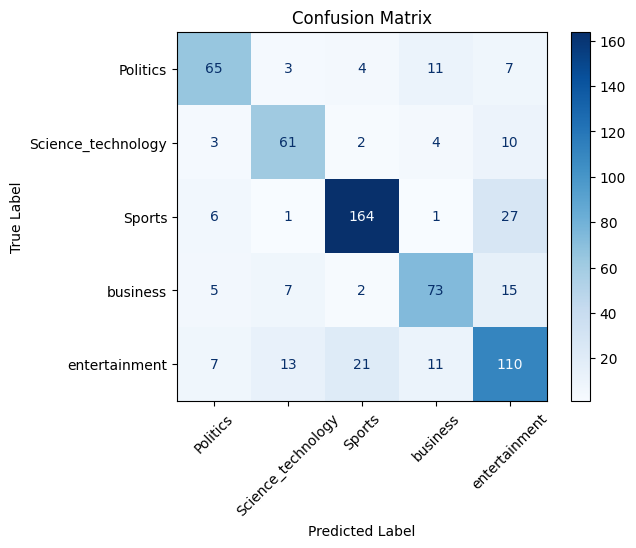

In [ ]:
#plot Classification report, confusion matrix
print('Without Resampling:')
confusion_matrix_plot(log_reg_model, X_test_scaled, y_test, label_encoder)

Without Resampling:


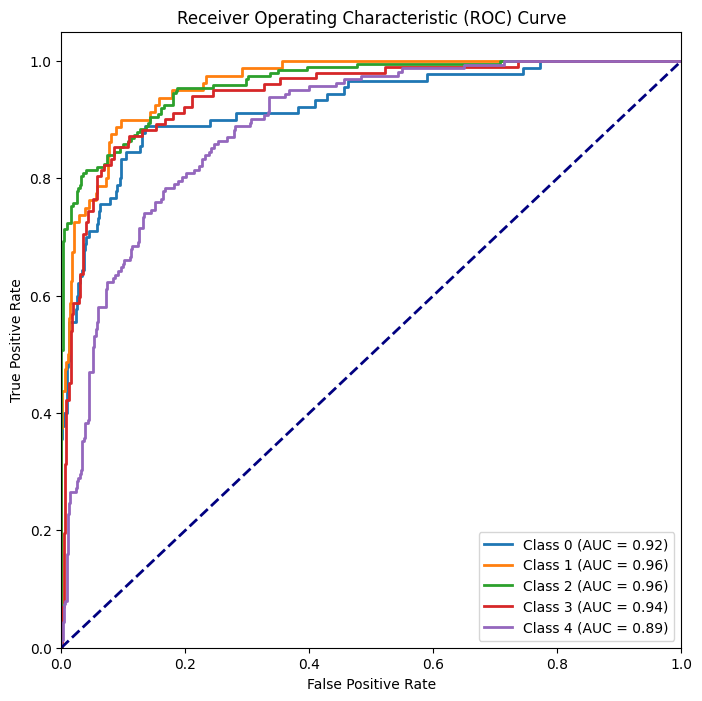

In [ ]:
# Plot RUC
print('Without Resampling:')
plot_roc(log_reg_model, X_test_scaled, y_test, n_classes=5)

With resampling

In [ ]:
# Initialize Logistic Regression model
log_reg_model_resampled = LogisticRegression(max_iter=1000)
log_reg_model_resampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

After Resampling:
Classification Report:
                     precision    recall  f1-score   support

          Politics       0.76      0.73      0.75        90
Science_technology       0.67      0.78      0.72        80
            Sports       0.88      0.82      0.85       199
          business       0.74      0.76      0.75       102
     entertainment       0.68      0.69      0.68       162

          accuracy                           0.76       633
         macro avg       0.75      0.76      0.75       633
      weighted avg       0.76      0.76      0.76       633



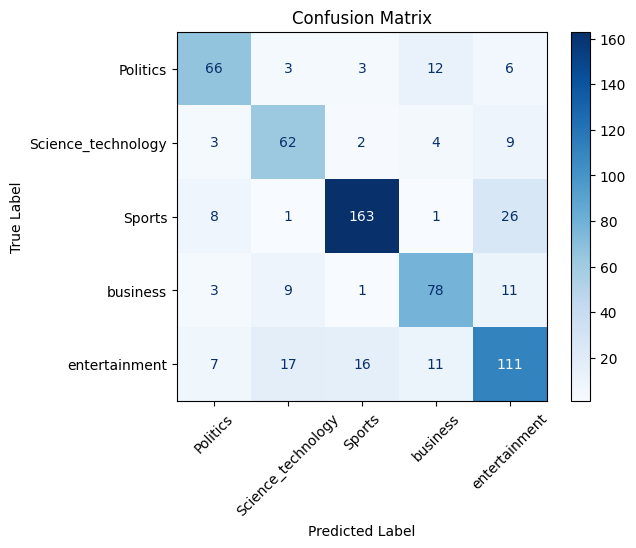

In [ ]:
print('After Resampling:')
confusion_matrix_plot(log_reg_model_resampled, X_test_scaled, y_test, label_encoder)

After Resampling:



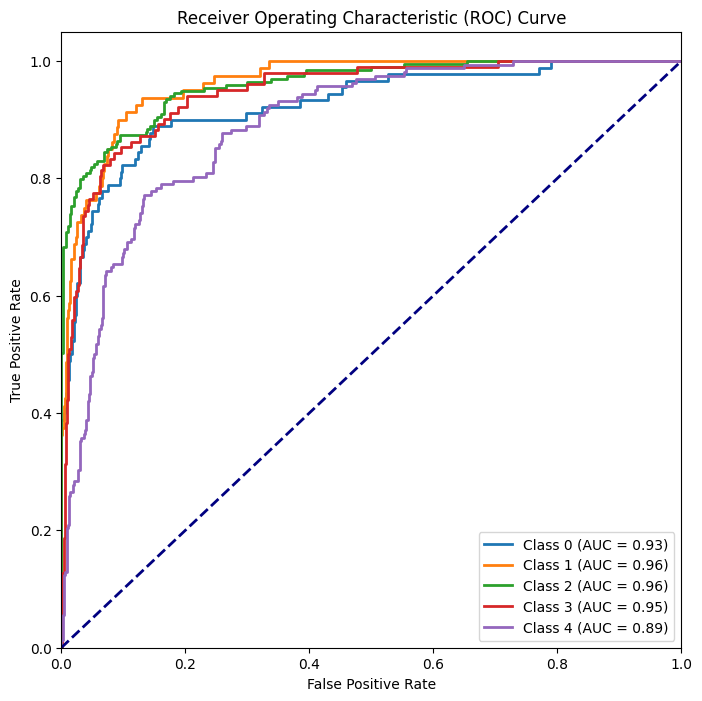

In [ ]:
# Plot RUC
print('After Resampling:\n')
plot_roc(log_reg_model_resampled, X_test_scaled, y_test, n_classes=5)

* Logistic Regression (After Resampling): Logistic Regression performed quite well, especially in the Sports category, showing decent recall and precision. The recall for Politics, though, is improved compared to the model without resampling.

* Logistic Regression (Without Resampling): Without resampling, Logistic Regression saw similar performance, with a slight drop in recall for Politics but strong accuracy for the Sports category.
* No significant Improvement was shown.

### 3.5.2. Random Forest (Ensemble method)

Without resampling

In [ ]:
# Initialize Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Without Resampling:
Classification Report:
                     precision    recall  f1-score   support

          Politics       0.75      0.53      0.62        90
Science_technology       0.77      0.66      0.71        80
            Sports       0.90      0.85      0.87       199
          business       0.71      0.67      0.69       102
     entertainment       0.61      0.81      0.69       162

          accuracy                           0.74       633
         macro avg       0.75      0.70      0.72       633
      weighted avg       0.76      0.74      0.74       633



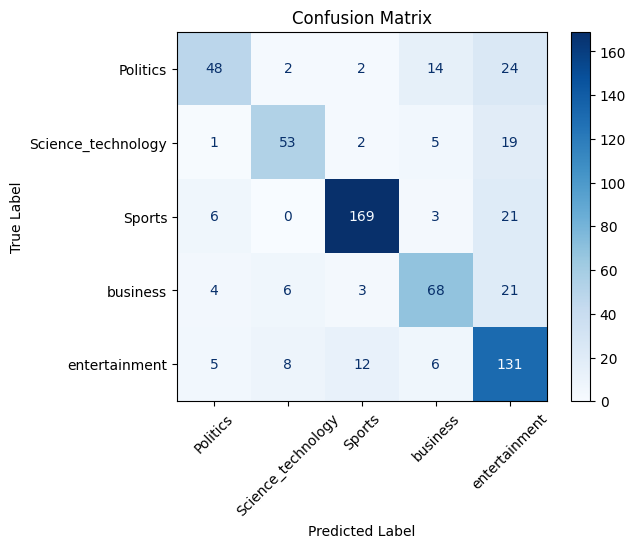

In [ ]:
#plot Classification report, confusion matrix
print("Without Resampling:")
confusion_matrix_plot(rf_model, X_test, y_test, label_encoder)

Without Resampling:



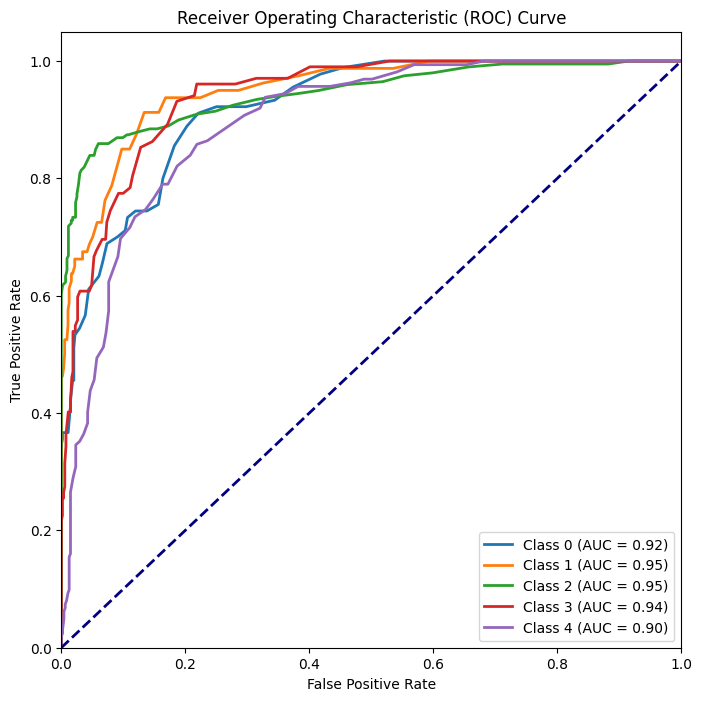

In [ ]:
#plot RUC
print('Without Resampling:\n')
plot_roc(rf_model, X_test, y_test, n_classes=5)

With Resampling

In [ ]:
X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)

In [ ]:
# Initialize Random Forest classifier
rf_model_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_model_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

After Resampling:
Classification Report:
                     precision    recall  f1-score   support

          Politics       0.68      0.60      0.64        90
Science_technology       0.77      0.66      0.71        80
            Sports       0.90      0.83      0.86       199
          business       0.70      0.73      0.71       102
     entertainment       0.64      0.77      0.69       162

          accuracy                           0.74       633
         macro avg       0.74      0.72      0.72       633
      weighted avg       0.75      0.74      0.75       633



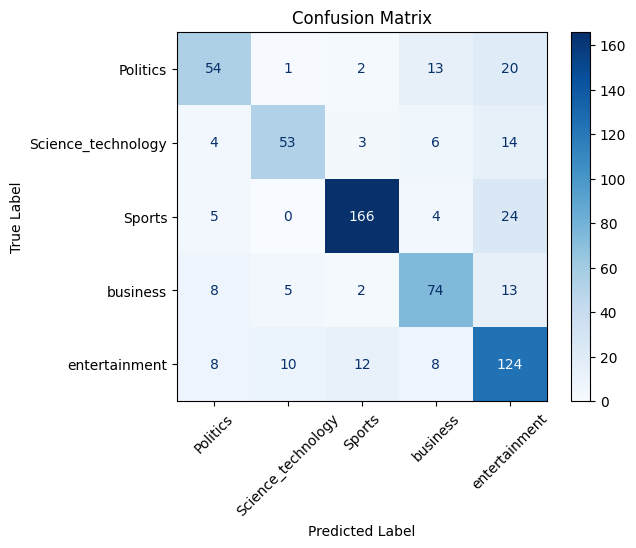

In [ ]:
#plot Classification report, confusion matrix
print('After Resampling:')
confusion_matrix_plot(rf_model_resampled, X_test, y_test, label_encoder)

After Resampling:



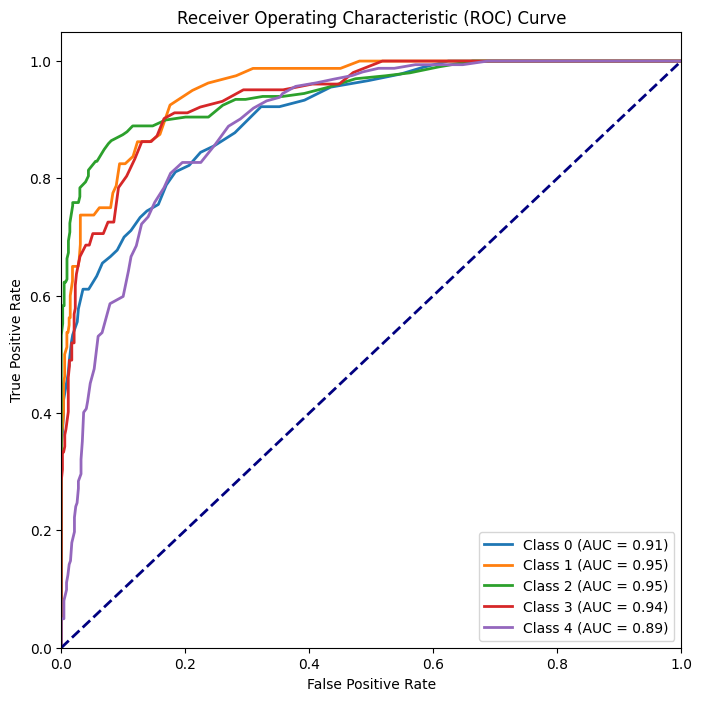

In [ ]:
#plot RUC
print('After Resampling:\n')
plot_roc(rf_model_resampled, X_test, y_test, n_classes=5)

* Random Forest (After Resampling): After resampling, the Random Forest model showed a slight improvement in recall for categories like Science_technology and Entertainment. However, it didn't show a large improvement in overall accuracy compared to FFFN.

* Random Forest (Without Resampling): Without resampling, Random Forest performed similarly to FFFN with slightly worse recall on certain categories like Politics and Science_technology. However, Sports remained a strong performer.

> Resampling did not lead to significant improvements, similar to the results seen with Logistic Regression. As a result, resampling will not be applied to the FFNN and XLM-R models.





### 3.5.3. Deep Learning Method (Non-Transformer)

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer with num_classes neurons
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)  # Converts logits into class probabilities
        return x

In [ ]:
# Training function with early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, device, patience=5):
    model.to(device)
    train_losses, test_losses, train_accs, test_accs = [], [], [], []

    best_loss = float("inf")  # Track best test loss
    early_stop_counter = 0    # Track epochs without improvement

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)

        # Evaluate on test data
        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        test_acc = correct / total
        test_losses.append(test_loss / len(test_loader))
        test_accs.append(test_acc)

        # Print only every 10 epochs or final epoch
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.4f}")

        # Early Stopping Logic
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]  # Update best loss
            early_stop_counter = 0       # Reset counter
        else:
            early_stop_counter += 1      # Increment counter if no improvement

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break  # Stop training

    return train_losses, test_losses, train_accs, test_accs


In [ ]:
# Plot loss and accuracy curves
def plot_loss_accuracy(train_losses, test_losses, train_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, test_accs, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

In [ ]:
# Classification report and confusion matrix
def evaluate_model(model, X_test, y_test, class_names, device):
    model.to(device)
    model.eval()

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs, 1)

    y_test = y_test.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# ROC Curve
def plot_roc_curve(model, X_test, y_test, class_names, device):
    model.to(device)
    model.eval()

    X_test = X_test.to(device)
    y_test = y_test.cpu().numpy()

    with torch.no_grad():
        y_scores = model(X_test).cpu().numpy()

    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextClassificationModel(input_dim=X_train.shape[1], num_classes=len(label_encoder.classes_))
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)

# Train the model
train_losses, test_losses, train_accs, test_accs = train_model( model, train_loader, test_loader, criterion, optimizer, epochs=150, device=device, patience=3)


Epoch 10/150: Train Loss: 1.3980, Train Acc: 0.5107, Test Loss: 1.3994, Test Acc: 0.5292
Epoch 20/150: Train Loss: 1.3173, Train Acc: 0.6327, Test Loss: 1.3133, Test Acc: 0.6193
Epoch 30/150: Train Loss: 1.2800, Train Acc: 0.6469, Test Loss: 1.2771, Test Acc: 0.6398
Epoch 40/150: Train Loss: 1.2566, Train Acc: 0.6631, Test Loss: 1.2582, Test Acc: 0.6382
Epoch 50/150: Train Loss: 1.2163, Train Acc: 0.7196, Test Loss: 1.2211, Test Acc: 0.7014
Epoch 60/150: Train Loss: 1.1920, Train Acc: 0.7405, Test Loss: 1.2008, Test Acc: 0.7220
Epoch 70/150: Train Loss: 1.1823, Train Acc: 0.7445, Test Loss: 1.1882, Test Acc: 0.7362
Epoch 80/150: Train Loss: 1.1662, Train Acc: 0.7539, Test Loss: 1.1791, Test Acc: 0.7441
Epoch 90/150: Train Loss: 1.1575, Train Acc: 0.7654, Test Loss: 1.1723, Test Acc: 0.7520
Epoch 100/150: Train Loss: 1.1522, Train Acc: 0.7713, Test Loss: 1.1673, Test Acc: 0.7583
Epoch 110/150: Train Loss: 1.1434, Train Acc: 0.7796, Test Loss: 1.1632, Test Acc: 0.7504
Epoch 120/150: Trai

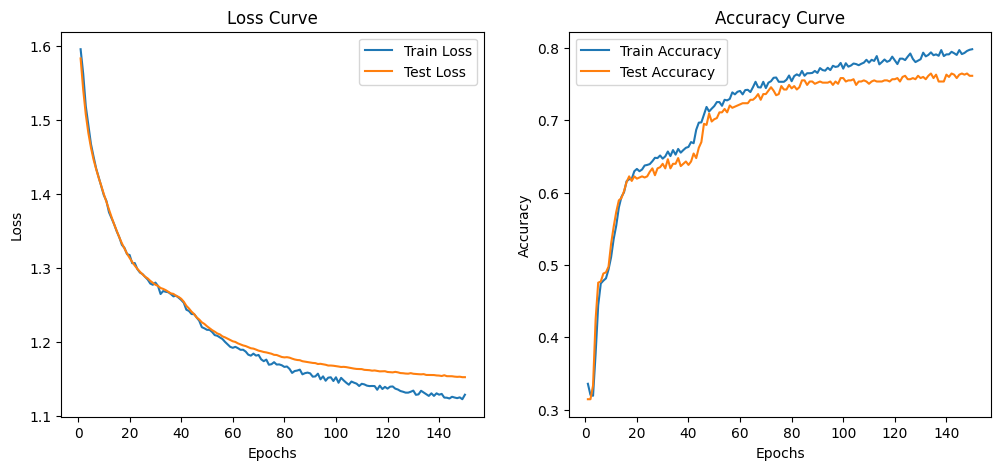

In [ ]:
# Plot loss and accuracy curves
plot_loss_accuracy(train_losses, test_losses, train_accs, test_accs)

Classification Report:
                     precision    recall  f1-score   support

          Politics       0.78      0.69      0.73        90
Science_technology       0.68      0.75      0.71        80
            Sports       0.90      0.83      0.86       199
          business       0.80      0.71      0.75       102
     entertainment       0.64      0.76      0.70       162

          accuracy                           0.76       633
         macro avg       0.76      0.75      0.75       633
      weighted avg       0.77      0.76      0.76       633



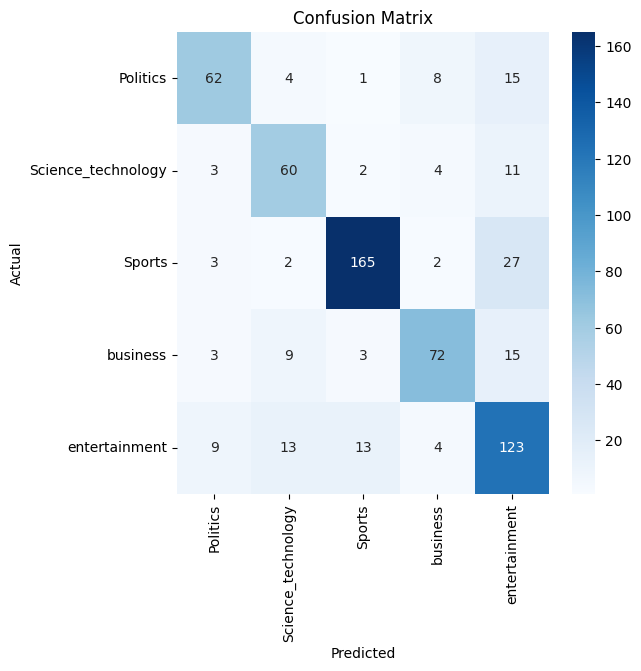

In [ ]:
# Evaluate the model
evaluate_model(model, X_test_tensor, y_test_tensor, class_names=label_encoder.classes_, device=device)

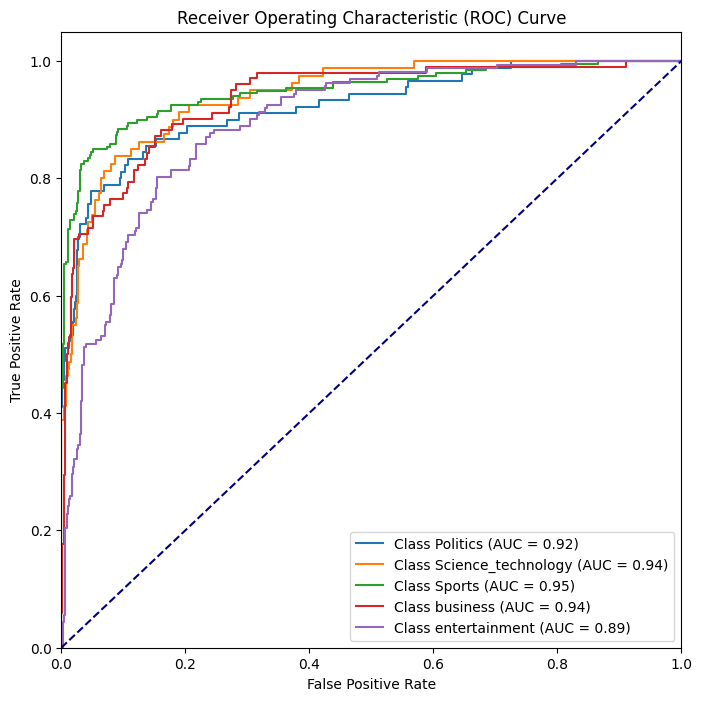

In [ ]:
# Plot ROC Curve
plot_roc_curve(model, X_test_tensor, y_test_tensor, class_names=label_encoder.classes_, device=device)

* The Feed-Forward Neural Network (FFFN) model performed well overall, with strong precision and recall for sports and politics. However, its performance on the entertainment category is lower in terms of precision.

### 3.5.4. Transformer Model (XLM-R)

In [ ]:
# Load pre-trained XLM-R model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["category"])  # Convert labels to numerical format

In [ ]:
# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42, stratify=df["label"]
)

In [ ]:
# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

In [ ]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

In [ ]:
# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/2532 [00:00<?, ? examples/s]

Map:   0%|          | 0/633 [00:00<?, ? examples/s]

In [ ]:
# Define the classification model
model = RobertaForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_encoder.classes_)
)

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

In [ ]:
# Disable WandB logging
%env WANDB_DISABLED=True
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Maximum number of epochs
    weight_decay=0.05,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    report_to="none",  # Disable WandB logging
    warmup_steps=500,
    logging_first_step=True,
    fp16=True,  # Mixed precision
    greater_is_better=True  # Higher accuracy is better
)

env: WANDB_DISABLED=True


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stops if no improvement in 3 evals
)

<ipython-input-777-59d7474f4c5e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.481800,1.382585,0.314376
2,0.916100,0.811508,0.786730
3,0.582200,0.516530,0.845182
4,0.477000,0.459600,0.862559
5,0.297500,0.423570,0.873618


TrainOutput(global_step=795, training_loss=0.8570773856444929, metrics={'train_runtime': 454.4519, 'train_samples_per_second': 27.858, 'train_steps_per_second': 1.749, 'total_flos': 3331075683594240.0, 'train_loss': 0.8570773856444929, 'epoch': 5.0})

In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.42357000708580017,
 'eval_accuracy': 0.8736176935229067,
 'eval_runtime': 4.4943,
 'eval_samples_per_second': 140.845,
 'eval_steps_per_second': 8.9,
 'epoch': 5.0}

In [ ]:
# Generate Predictions & Metrics
predictions = trainer.predict(dataset["test"])
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = test_labels

# 🔹 Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Classification Report:

                    precision    recall  f1-score   support

          Politics       0.86      0.81      0.83        90
Science_technology       0.90      0.89      0.89        80
            Sports       0.95      0.91      0.93       199
          business       0.82      0.83      0.83       102
     entertainment       0.82      0.88      0.85       162

          accuracy                           0.87       633
         macro avg       0.87      0.86      0.87       633
      weighted avg       0.88      0.87      0.87       633



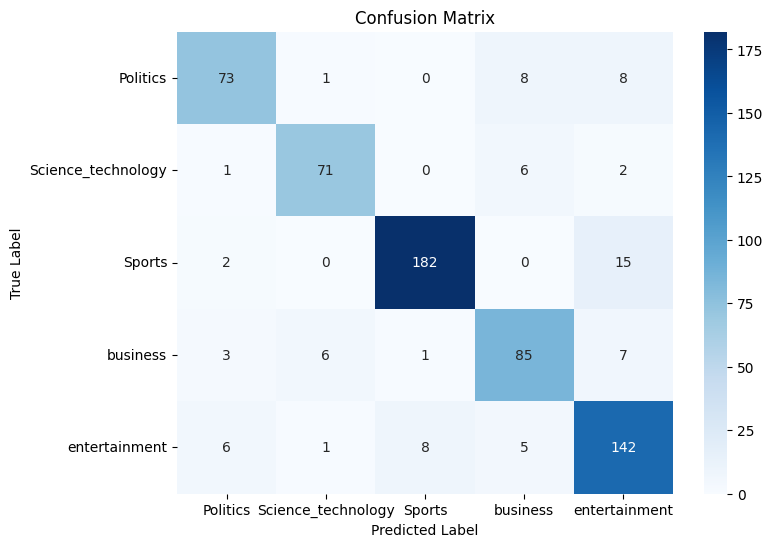

In [ ]:
#  Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#  Display DataFrame with Predictions

test_df["predicted_label"] = label_encoder.inverse_transform(y_pred)  # Convert back to category names
test_df["true_label"] = label_encoder.inverse_transform(y_true)

print("\nSample Predictions:")
display(test_df.head(25))  # Show first 10 rows


Sample Predictions:


,text,label,predicted_label,true_label
0,ලිපි ලේඛන තියෙනවා. ”,3,business,business
1,කඩුලු – 305,2,Sports,Sports
2,එන මහ මැතිවරණයේදී තමන් මහින්ද රාජපක්‍ෂ හිටපු ජ...,0,Politics,Politics
3,ටැමිල් යුනියන් ක්‍රිකට් කණ්ඩායම නියෝජනය කරමින්...,2,Sports,Sports
4,මේ සම්බන්ධයෙන් නයිමූර් රහමන් බංග්ලාදේශ ක්‍රිකට...,2,Sports,Sports
5,තවදුරටත් මාගේ සේවාදායකයා පවසා සිටින්නේ කෙසේ නම...,3,business,business
6,කලක් තිස්සේ රහසක්ව පැවති ඉන්දීය ක්‍රිකට් ක්‍රී...,2,Sports,Sports
7,"ඒ අනුව, අදාළ වෛද්‍යවරයාගේ බිරිඳගේ කුසෙහි තැන්ප...",0,entertainment,Politics
8,"""ඒක එහෙම වේගෙන යනවා වෙන්න පුළුවන්. නමුත් යම් ම...",4,entertainment,entertainment
9,"ඒ, ළඟදී තිරගත වීමට නියමිත PK චිත්‍රපටයේ පුචාරක...",4,entertainment,entertainment


### Intepretation of Results:


| **Model**                          | **Precision** | **Recall** | **F1-Score** | **Accuracy** |
|------------------------------------|---------------|------------|--------------|--------------|
| **FFFN**                            | 0.76          | 0.75       | 0.75         | 0.76         |
| **RF (After Resampling)**          | 0.74          | 0.72       | 0.72         | 0.74         |
| **RF (Without Resampling)**        | 0.75          | 0.70       | 0.72         | 0.74         |
| **Logistic Regression (After Resampling)** | 0.76          | 0.73       | 0.75         | 0.76         |
| **Logistic Regression (Without Resampling)** | 0.75          | 0.74       | 0.74         | 0.75         |
| **XLM-R**                           | 0.88          | 0.87       | 0.87         | 0.87         |



General Observations:

1. Resampling generally improves recall, especially for categories that had a lower initial recall, like Politics and Entertainment.

2.  Sports is a category that seems to perform well across all models, with high precision and recall.

3. Resampling doesn't significantly change the overall accuracy, but it does affect category-specific performance, improving the recall for some categories.

4. XLM-R shows the highest overall performance in terms of precision, recall, and F1-score across all categories compared to the other models, with particularly strong performance in Sports.

5. FFNN, Random Forest, and Logistic Regression show slightly lower accuracy and slightly more variation in performance across different categories.

6. XLM-R has a good balance across all categories, achieving an accuracy of 0.87, with a strong recall in Science_technology and Sports, which indicates the model's ability to handle different types of news categories effectively.

> In the results, it is important to note that the Logistic Regression , Random Forest, and Feed-Forward Neural Network models used a custom-trained FastText model and the Byte Pair Encoding (BPE) tokenizer for Sinhala text.

> While the custom FastText embeddings and BPE tokenizer provided a solid foundation for the LR, RF, and FFNN models, the XLM-R model, being pre-trained on a large multilingual corpus, benefited from its ability to generalize across multiple languages, including Sinhala.

Identified Following as probable reasons for this gap in performance:

1. Contextualized Representations – XLM-R captures word meanings based on context, unlike FastText, which provides static embeddings.

2. Multilingual Pretraining – Trained on 100+ languages, XLM-R benefits from shared linguistic patterns, improving generalization.

3. Transformers vs. Shallow Models – XLM-R's self-attention mechanism captures long-range dependencies better than simpler models.

4. Advanced Tokenization – SentencePiece handles rare and out-of-vocabulary words better than BPE.

5. Robust Feature Extraction – Pretraining on diverse text sources helps XLM-R generalize better than custom-trained FastText.

6. Since Entertainment and Sports are closely related their keywords were overlapping thus it was seen that entertainment news were categorized as sports news wrongly.